In [2]:
import pandas as pd
df = pd.read_csv('Consumer_Complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217
1,10/01/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/05/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06/10/2014,Closed with explanation,Yes,Yes,885638
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760


In [3]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310259 entries, 1 to 1094510
Data columns (total 18 columns):
Date received                   310259 non-null object
Product                         310259 non-null object
Sub-product                     258076 non-null object
Issue                           310259 non-null object
Sub-issue                       206641 non-null object
Consumer complaint narrative    310259 non-null object
Company public response         150060 non-null object
Company                         310259 non-null object
State                           309102 non-null object
ZIP code                        307615 non-null object
Tags                            53312 non-null object
Consumer consent provided?      310259 non-null object
Submitted via                   310259 non-null object
Date sent to company            310259 non-null object
Company response to consumer    310257 non-null object
Timely response?                310259 non-null object
Consumer 

In [5]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [6]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [7]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [8]:
df['category_id'] = df['Product'].factorize()[0]
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [9]:
df.head()

,Product,Consumer_complaint_narrative,category_id
1,Credit reporting,I have outdated information on my credit repor...,0
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...,1
7,Credit reporting,An account on my credit report has a mistaken ...,0
12,Debt collection,This company refuses to provide me verificatio...,2
16,Debt collection,This complaint is in regards to Square Two Fin...,2


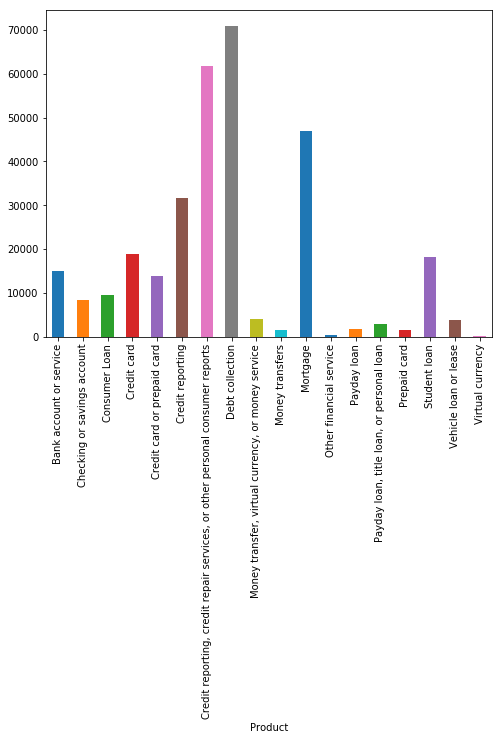

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative)
labels = df.category_id
features.shape

(310259, 614055)

In [15]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
       . bank
       . overdraft
  . Most correlated bigrams:
       . overdraft fees
       . checking account
# 'Checking or savings account':
  . Most correlated unigrams:
       . overdraft
       . deposit
  . Most correlated bigrams:
       . overdraft fees
       . checking account
# 'Consumer Loan':
  . Most correlated unigrams:
       . vehicle
       . car
  . Most correlated bigrams:
       . car loan
       . auto loan
# 'Credit card':
  . Most correlated unigrams:
       . macy
       . card
  . Most correlated bigrams:
       . american express
       . credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
       . express
       . card
  . Most correlated bigrams:
       . american express
       . credit card
# 'Credit reporting':
  . Most correlated unigrams:
       . equifax
       . experian
  . Most correlated bigrams:
       . verify accounts
       . credit report
# 'Credit reporting, 

In [16]:


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)



In [17]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [18]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [19]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,Product,Consumer_complaint_narrative,category_id
12,Debt collection,This company refuses to provide me verificatio...,2


In [20]:
df[df['Consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

,Product,Consumer_complaint_narrative,category_id
61,Credit reporting,I am disputing the inaccurate information the ...,0


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/cit/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


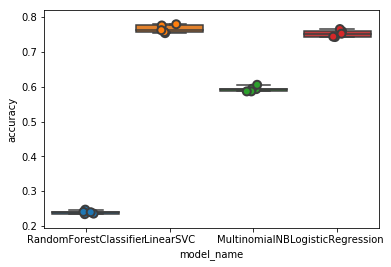

In [22]:


import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()



In [23]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.765396
LogisticRegression        0.752487
MultinomialNB             0.593059
RandomForestClassifier    0.239487
Name: accuracy, dtype: float64

In [24]:


from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



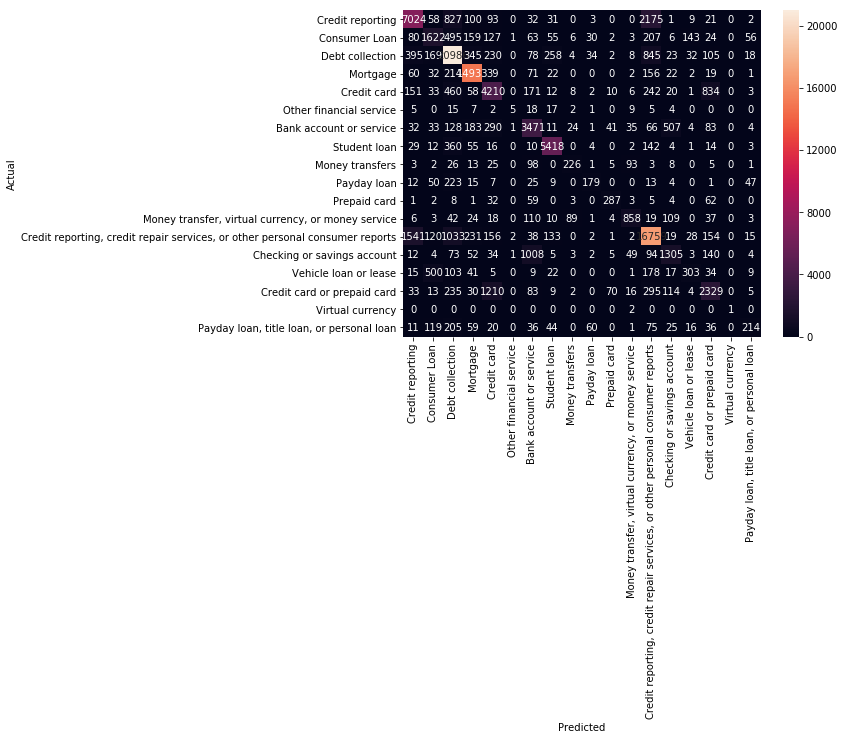

In [25]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [26]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'Consumer Loan' predicted as 'Credit reporting' : 80 examples.


,Product,Consumer_complaint_narrative
370897,Consumer Loan,I requested contracts bearing my signature and...
578450,Consumer Loan,RE : LEXUS FINANCIAL SERVICES ( XXXX ) /TOYOTA...
470978,Consumer Loan,CAN AFFES CHARGE US XXXX PAYMENT ON A PAYMENT ...
724531,Consumer Loan,Account number : XXXX I had a balance in XXXX ...
411615,Consumer Loan,The last payment made on this Account was XXXX
613806,Consumer Loan,On XX/XX/XXXX I applied for credit at XXXX thr...
628511,Consumer Loan,Paypal Credit denied my application for an acc...
855937,Consumer Loan,Submitted Case number : XXXX ] on XXXX/XXXX/XX...
235119,Consumer Loan,My complaint is with EQUIFAX. EQUIFAX has no o...
292259,Consumer Loan,A claim was submitted sometime ago and was rec...



'Debt collection' predicted as 'Credit reporting' : 395 examples.


,Product,Consumer_complaint_narrative
862201,Debt collection,On XX/XX/2014 .AMOUNTS ARE $ XXXX.THIS IS PAYD...
220642,Debt collection,I received a credit alert from my credit monit...
386651,Debt collection,I have tried to contact Global credit to infor...
543528,Debt collection,I have requested removal of an item from my cr...
1065087,Debt collection,I have tried to contact Equifax several times ...
1029546,Debt collection,The company left a derogatory remark on my cre...
729194,Debt collection,I have continued to diapute this company i hav...
918354,Debt collection,TRS Recover ( Telecheck ) will not allow me to...
262831,Debt collection,"To whom this may concern, XX/XX/XXXX Apparentl..."
52899,Debt collection,"Year XXXX, I activated a credit card through A..."



'Mortgage' predicted as 'Credit reporting' : 60 examples.


,Product,Consumer_complaint_narrative
191451,Mortgage,IndyMac/OneWest/XXXX and XXXX XXXX XXXX duplic...
369828,Mortgage,This acct is reflecting as in Dispute on my cr...
513356,Mortgage,"I went through a foreclosure with WellsFargo, ..."
737984,Mortgage,I was part of a XXXX.settlement : Consent Orde...
604628,Mortgage,"I recently checked my credit score, it went do..."
21430,Mortgage,Here 's the documentation you requested. As I ...
156927,Mortgage,Filled a complaint on XXXX/XXXX/2015 ( XXXX ) ...
229891,Mortgage,WellsFargo did not pay XXXX County property ta...
182364,Mortgage,SLS refuses to give me the proper XX/XX/XXXX X...
723057,Mortgage,I was asked ( as I was leaving the branch ) to...



'Credit card' predicted as 'Credit reporting' : 151 examples.


,Product,Consumer_complaint_narrative
677445,Credit card,"My first is XXXX, Last name : XXXX XXXX last X..."
448852,Credit card,I disputed with the creditor directly ( see at...
787983,Credit card,XXXX sent me an email informing me of a past d...
582367,Credit card,"After reviewing my credit report, this company..."
5495,Credit card,I am unable to log in to the Discover website ...
495894,Credit card,applied for CareCredit for my dog 's XXXX and ...
535181,Credit card,I wo n't go into it but citi pulled XXXX and d...
563353,Credit card,Account was paid and closed.
859248,Credit card,Back in XX/XX/2016 I did not receive my credit...
132004,Credit card,Have stated to Capital One numerous times that...



'Bank account or service' predicted as 'Credit reporting' : 32 examples.


,Product,Consumer_complaint_narrative
627158,Bank account or service,Placed a call to customer service to learn why...
475979,Bank account or service,Was opening a new cd @ my financial institutio...
578309,Bank account or service,recd text from XXXXXXXXXXXX
509137,Bank account or service,I paid my overdraft accout about a year ago am...
724678,Bank account or service,XXXX accounts were opened under my name and so...
673189,Bank account or service,After 4+ years of perfect transactions and fee...
59738,Bank account or service,Attempts have been made to improve my credit s...
673923,Bank account or service,I got a change of address notification in the ...
700458,Bank account or service,"Hello, I went into XXXX XXXX XXXX to pen an ac..."
651456,Bank account or service,"On XXXX/XXXX/15, I submitted a complaint lette..."



'Student loan' predicted as 'Credit reporting' : 29 examples.


,Product,Consumer_complaint_narrative
17291,Student loan,Please have lates removed from XXXX 2010 XXXX ...
528227,Student loan,"XX/XX/XXXX, I filed a complaint against the NJ..."
995015,Student loan,information is not correct. the balance had be...
568641,Student loan,"XXXX As in that case, there is no circumstance..."
727291,Student loan,I filed Chapter XXXX bankruptcy ( XXXX ) and s...
248102,Student loan,This dispute involves incomplete and inaccurat...
1027988,Student loan,The Dept of Education and XXXX have listed mul...
438267,Student loan,My brother has assumed responsibility for payi...
783243,Student loan,So I disputed an account on my credit report a...
426158,Student loan,i was attending school had been XXXX but my st...



'Payday loan' predicted as 'Credit reporting' : 12 examples.


,Product,Consumer_complaint_narrative
667614,Payday loan,See below : I would like to register a formal ...
685270,Payday loan,I submitted a claim earlier about XXXX XXXX XX...
215045,Payday loan,I was charged fee 's and interest I did n't kn...
3997,Payday loan,My identity was stolen in XX/XX/2009. A XXXX X...
171098,Payday loan,I was refused a PayDay loan because they have ...
696551,Payday loan,None of the aboveMy complaint is that the CFPB...
404029,Payday loan,XXXX Credit Bureau informed me via CFPB # XXXX...
327187,Payday loan,Progreso Financiero is Poising my Credit Score...
727745,Payday loan,I have sent a copy of my old bank statement sh...
233639,Payday loan,On XXXX/XXXX/15 I noticed an unauthorized depo...



'Money transfer, virtual currency, or money service' predicted as 'Credit reporting' : 6 examples.


,Product,Consumer_complaint_narrative
1037202,"Money transfer, virtual currency, or money ser...",XXXX XXXX XXXX Clerk of Court RM:XXXX United S...
907754,"Money transfer, virtual currency, or money ser...",Navy Federal Credit union does not want to con...
1015849,"Money transfer, virtual currency, or money ser...",XXXX I call XXXX for Tech support because I wa...
937651,"Money transfer, virtual currency, or money ser...",Experian is absolutely refusing to give me a r...
1066140,"Money transfer, virtual currency, or money ser...",I had a balance of roughly {$2000.00} in my XX...
258026,"Money transfer, virtual currency, or money ser...",On XXXX / XXXX / XXXX at XXXX XXXX our...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 1541 examples.


,Product,Consumer_complaint_narrative
995882,"Credit reporting, credit repair services, or o...","On XXXX XXXX, 2017, I mailed a letter to Equif..."
225513,"Credit reporting, credit repair services, or o...",Non-Response from Documents supplied
794101,"Credit reporting, credit repair services, or o...",RE : XXXX and XXXX Credit Report XXXX ...
798212,"Credit reporting, credit repair services, or o...",I have a IRS lien in the public record in XXX...
1007252,"Credit reporting, credit repair services, or o...",I have sent multiple letters to Experian to re...
1091485,"Credit reporting, credit repair services, or o...",Experian says that I have to pay them to put a...
955874,"Credit reporting, credit repair services, or o...",Please have the following items remove from my...
889570,"Credit reporting, credit repair services, or o...","I have numerous Hard Inquiries on my report, I..."
1025218,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX I received my credit/consumer re...
1008634,"Credit reporting, credit repair services, or o...",Equifax refuses to process a request to block ...



'Checking or savings account' predicted as 'Credit reporting' : 12 examples.


,Product,Consumer_complaint_narrative
876686,Checking or savings account,Wrote Chex system a letter to remove accounts ...
1045549,Checking or savings account,I had an outstanding balance with XXXX XXXX XX...
972437,Checking or savings account,around XXXX XXXX i noticed my XXXX account was...
1001209,Checking or savings account,I am contacting you to file an official compla...
889701,Checking or savings account,CHEX SYSTEMS IS STATING THAT XXXX XXXX XXXX SU...
960482,Checking or savings account,I need you to send XXXX my updated transaction...
899572,Checking or savings account,I am a victim of identity theft. I have previo...
867902,Checking or savings account,Banks are requiring that their customers who w...
801853,Checking or savings account,Vanguard will not release information on an a...
1025634,Checking or savings account,I was denied a savings account per email they ...



'Vehicle loan or lease' predicted as 'Credit reporting' : 15 examples.


,Product,Consumer_complaint_narrative
998064,Vehicle loan or lease,My ex / children 's father stole my identity a...
1016670,Vehicle loan or lease,On X/X/17 I bought my lease out on my XXXX. Th...
964790,Vehicle loan or lease,This company has over charged me for a car tha...
257091,Vehicle loan or lease,contact XXXX letting them know this is not m...
1073401,Vehicle loan or lease,I was in tbe hospital in XXXX was very sick fo...
1081835,Vehicle loan or lease,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX, Georgia, X..."
996598,Vehicle loan or lease,"XX/XX/XXXX date of loan, amount was {$8300.00}..."
965222,Vehicle loan or lease,Company is attempting to charge a {$1100.00} t...
268190,Vehicle loan or lease,I 'm trying to apply for a mortgage loan but ...
853565,Vehicle loan or lease,I paid off my vehicle in XX/XX/2009 and I'm no...



'Credit card or prepaid card' predicted as 'Credit reporting' : 33 examples.


,Product,Consumer_complaint_narrative
977764,Credit card or prepaid card,"Identity theft, known per local XXXX report XX..."
836901,Credit card or prepaid card,"Dear Investigator, Elanco Financial Svc. sh ow..."
256634,Credit card or prepaid card,Bank Of America Intentionally Robs Me and i ca...
1062558,Credit card or prepaid card,Capital one changed my due date twice apparent...
824624,Credit card or prepaid card,"In XXXX this year, I purchased an item on the ..."
828639,Credit card or prepaid card,On XX/XX/XXXX an XXXX XXXX retail credit card ...
945205,Credit card or prepaid card,"Hi, This is XXXX XXXX XXXX. I want let you kno..."
1026192,Credit card or prepaid card,Inquired about {$300.00} increase and did not ...
948344,Credit card or prepaid card,My ex-wife and her boy friend sold my home und...
884681,Credit card or prepaid card,"About a month ago, I requested, via email to X..."



'Payday loan, title loan, or personal loan' predicted as 'Credit reporting' : 11 examples.


,Product,Consumer_complaint_narrative
986663,"Payday loan, title loan, or personal loan","In talking to a customer service rep, I was as..."
1056142,"Payday loan, title loan, or personal loan",Told me it will fix my credit but denied me st...
950301,"Payday loan, title loan, or personal loan",I ca n't get any of my personal info
77632,"Payday loan, title loan, or personal loan",I can not log into my account as there is a li...
800475,"Payday loan, title loan, or personal loan",I am languished by a horrible process. I suspe...
988066,"Payday loan, title loan, or personal loan",Creditor has been unable to provide proof of a...
1082705,"Payday loan, title loan, or personal loan",Time finance is still reporting this account a...
798094,"Payday loan, title loan, or personal loan",I apply for a loan online and for the amount o...
906105,"Payday loan, title loan, or personal loan",Company agree to remove negative information f...
837571,"Payday loan, title loan, or personal loan",I agreed to a settlement on XXXX XXXX and ...



'Credit reporting' predicted as 'Consumer Loan' : 58 examples.


,Product,Consumer_complaint_narrative
49933,Credit reporting,It has been XXXX months since I filed a compla...
453943,Credit reporting,I was recently pre-approved for a car loan thr...
16920,Credit reporting,the XXXX sold me a car later they do n't want ...
305223,Credit reporting,We have a leased XXXX from toyota financial se...
135554,Credit reporting,I HAVE RECIVED LETTERS IN THE MAIL REGARDING A...
316614,Credit reporting,XXXX XXXX did not take my payment as they clai...
506121,Credit reporting,I 've done extended research on how creditors ...
412622,Credit reporting,I traded my car in on the XXXX the company tha...
84941,Credit reporting,"Santander Consumer USA , Inc. sent me a letter..."
599136,Credit reporting,I never signed nor endorsed any contract or ap...



'Debt collection' predicted as 'Consumer Loan' : 169 examples.


,Product,Consumer_complaint_narrative
439470,Debt collection,Wells Fargo Dealer Services is reporting wrong...
548585,Debt collection,I have an unsecured loan with BorrowersFirst a...
519411,Debt collection,The vehicle had {$1500.00} left on the loan an...
1045257,Debt collection,Owed 4000 on a car loan had horrible family is...
35863,Debt collection,I took a loan for XXXX paid off the loan of XX...
1030741,Debt collection,There is an automobile account that was opened...
278642,Debt collection,Delinquent on account due to husband losing jo...
836508,Debt collection,"On the XXXX of XXXX this year, we turned i..."
996476,Debt collection,"In XX/XX/XXXX, I purchased a car ( XXXX XXXX X..."
87239,Debt collection,I have a 60 day late notice on my credit score...



'Mortgage' predicted as 'Consumer Loan' : 32 examples.


,Product,Consumer_complaint_narrative
1027037,Mortgage,In XX/XX/XXXX I attempted to refinance my line...
145384,Mortgage,I have banked with Navy Federal Credit Union f...
600008,Mortgage,This complaint is against Springleaf Financial...
546327,Mortgage,I 'm requesting information about my loan to t...
1055439,Mortgage,During the buying processing of a home under c...
510131,Mortgage,If you make your payment on line and it is the...
253801,Mortgage,I have made my payments online through my XXXX...
102097,Mortgage,I believe I am a victim on predatory lending. ...
85018,Mortgage,Principal balance as of XXXX/XXXX/15 was {$660...
28581,Mortgage,My loan is through PennyMac. I pay it at the e...



'Credit card' predicted as 'Consumer Loan' : 33 examples.


,Product,Consumer_complaint_narrative
85699,Credit card,I would like to bring to someone 's attention ...
113053,Credit card,My contact information Mailing address XXXX ...
661232,Credit card,"On XXXX XXXX, we have taken out a credit accou..."
202039,Credit card,We are a XXXX XXXX and were told by the store ...
771361,Credit card,I had a payment due for a line of credit from ...
771362,Credit card,Some how when I logged into PayPal I had a cre...
82923,Credit card,There was fraud committed against me in XXXX 2...
612942,Credit card,I would like your assistance in obtain feedbac...
51296,Credit card,I contacted Synchrony Bank because I found out...
386378,Credit card,I had a dispute for XXXX and they will not giv...



'Bank account or service' predicted as 'Consumer Loan' : 33 examples.


,Product,Consumer_complaint_narrative
627218,Bank account or service,Today I attempted to pay off a loan with BB & ...
291879,Bank account or service,This is a notice to cease unauthorized inquire...
104032,Bank account or service,I feel like I was discriminated by TD bank in ...
750251,Bank account or service,I am a salesman for a local roofing and constr...
376332,Bank account or service,Wells Fargo continue to charge me late fees on...
83496,Bank account or service,I tried to dispute this case with BB & T and w...
293462,Bank account or service,Citibank Checking account balance falls negati...
202993,Bank account or service,I just read an article in the XXXX XXXX XXXX a...
789585,Bank account or service,Applied for loan for hot tub purchase from Wel...
18049,Bank account or service,have a personal loan with TD Bank terms are fi...



'Student loan' predicted as 'Consumer Loan' : 12 examples.


,Product,Consumer_complaint_narrative
118865,Student loan,My daughter has informed me that she has conta...
352967,Student loan,I requested proof that this loan was mine with...
224550,Student loan,Well Fargo input my loan as a $ XXXX/month pay...
113625,Student loan,I 've been trying to get installment pymnts th...
1021213,Student loan,This is my second complaint against my loan se...
501371,Student loan,I use XXXX XXXX XXXX to pay for college. They ...
170869,Student loan,I received a prescreened offer from SoFi to re...
665195,Student loan,I had fallen behind on my loan and reached an ...
422390,Student loan,In XXXX of 2015 we sent in XXXX payments for b...
860367,Student loan,I have student loan with XXXX ( XXXX XXXX XXXX...



'Payday loan' predicted as 'Consumer Loan' : 50 examples.


,Product,Consumer_complaint_narrative
563775,Payday loan,I signed the loan agreement with disclosed rat...
747693,Payday loan,Applied for XXXX dollar loan lende wanted 24 p...
563773,Payday loan,I received a mail from Mobiloans that I was pr...
660983,Payday loan,I 've just had to get my car repaired on credi...
103162,Payday loan,Received a check for {$1200.00} from Republic ...
622551,Payday loan,I just received a call from XXXX XXXX starting...
289341,Payday loan,"I took out this internet loan, {$300.00} and h..."
598778,Payday loan,I was given a loan of {$650.00} and was told t...
5565,Payday loan,I have a loan through a loan company and they ...
425269,Payday loan,I had signed up for a loan through Big Picture...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Consumer Loan' : 120 examples.


,Product,Consumer_complaint_narrative
837147,"Credit reporting, credit repair services, or o...","I applied for a personal loan, not a title loa..."
878699,"Credit reporting, credit repair services, or o...",I purchased a car and the dealership paid off ...
280364,"Credit reporting, credit repair services, or o...",I was scammed by Ford Motor Credit. aprox X...
953872,"Credit reporting, credit repair services, or o...",I had a very unusual situation with Toyota Fin...
283032,"Credit reporting, credit repair services, or o...",In XXXX I financed a motorcycle through Har...
802253,"Credit reporting, credit repair services, or o...",financial hardship caused a late payment XX/XX...
924738,"Credit reporting, credit repair services, or o...",This account with Ford was a lease. This accou...
865260,"Credit reporting, credit repair services, or o...","OnXXXX 2016, my Mercedes Benz lease was transf..."
906321,"Credit reporting, credit repair services, or o...",In XX/XX/XXXX me and my husband ( XXXX and XXX...
864683,"Credit reporting, credit repair services, or o...",I XXXX XXXX paid off a vehicle lease several y...



'Vehicle loan or lease' predicted as 'Consumer Loan' : 500 examples.


,Product,Consumer_complaint_narrative
980639,Vehicle loan or lease,I bought a used XXXX XXXX and XXXX said they w...
943566,Vehicle loan or lease,"Hello, I received a letter some years ago stat..."
1043532,Vehicle loan or lease,Purchased a new vehicle and was financed throu...
822284,Vehicle loan or lease,In XX/XX/XXXX I received a used auto loan from...
1012535,Vehicle loan or lease,I obtained an auto loan with Capital One Auto ...
268775,Vehicle loan or lease,"I have an auto loan through Bank of America, I..."
995198,Vehicle loan or lease,On XXXX/XXXX/XXXX at the XXXX of XXXX dealersh...
939305,Vehicle loan or lease,My car was wrecked on XX/XX/XXXX and deemed a ...
800621,Vehicle loan or lease,My vehicle was repossessed in XX/XX/2015 in th...
581794,Vehicle loan or lease,I have a five year car loan with capital one b...



'Credit card or prepaid card' predicted as 'Consumer Loan' : 13 examples.


,Product,Consumer_complaint_narrative
996925,Credit card or prepaid card,Charge approximately % 2500- {$3000.00} per mo...
409339,Credit card or prepaid card,I paid {$700.00} on my Wells Fargo credit card...
1051504,Credit card or prepaid card,GreenSky Credit and XXXX XXXX bad practice of ...
1087332,Credit card or prepaid card,XX/XX/2017 I applied and was approved for a XX...
1079909,Credit card or prepaid card,In XXXX of 2016 I was late making my payment d...
1082670,Credit card or prepaid card,In XXXX of 2014 I went to Wells Fargo to apply...
985719,Credit card or prepaid card,Submitted paperwork to navy federal credit uni...
278498,Credit card or prepaid card,"Hi, I am complaining abou t the Paypal Credit ..."
972120,Credit card or prepaid card,Bank of America insisted that I make large pay...
875167,Credit card or prepaid card,Sychrony bank has misleading and fraudulent in...



'Payday loan, title loan, or personal loan' predicted as 'Consumer Loan' : 119 examples.


,Product,Consumer_complaint_narrative
876121,"Payday loan, title loan, or personal loan",I got a personal loan from XXXX XXXX. I made a...
266938,"Payday loan, title loan, or personal loan","Good day, Sir/Madam. I have a complaint ab..."
797610,"Payday loan, title loan, or personal loan","I have a loan with a "" company '' called XXXX ..."
956807,"Payday loan, title loan, or personal loan","I have a loan with personal finance in XXXX, I..."
1079324,"Payday loan, title loan, or personal loan",I applied for a loan to get XXXX XXXX at my ey...
812918,"Payday loan, title loan, or personal loan",XX/XX/2016 due to an accident and getting my c...
1072698,"Payday loan, title loan, or personal loan",When I filed an application for a loan I clear...
1058527,"Payday loan, title loan, or personal loan",This is my third attempt in trying to resolve ...
280401,"Payday loan, title loan, or personal loan",I received my loan from Title Max XXXX XX...
906558,"Payday loan, title loan, or personal loan","Lendmark Financial in XXXX XXXX, North Carolin..."



'Credit reporting' predicted as 'Debt collection' : 827 examples.


,Product,Consumer_complaint_narrative
127632,Credit reporting,im in the process of identity theft from my fa...
773596,Credit reporting,There is an account listed that is not mine re...
153553,Credit reporting,will not remove XXXX or XXXX from report. \nco...
361553,Credit reporting,Collection account was deleted from Jana Ferre...
495245,Credit reporting,Experian is reporting a collection item by XXX...
289766,Credit reporting,TeleCheck declined my check not based on money...
472943,Credit reporting,"After viewing a copy of my credit report, I no..."
373989,Credit reporting,XXXX XXXX XXXX is reporting a collection for a...
694641,Credit reporting,I had XXXX lens on my report which Was paid in...
503049,Credit reporting,1 account is not mine 2 accounts I did not acc...



'Consumer Loan' predicted as 'Debt collection' : 495 examples.


,Product,Consumer_complaint_narrative
213237,Consumer Loan,I went through debt consolidation with XXXX. O...
620647,Consumer Loan,A gentleman by the name of XXXX XXXX has been ...
417468,Consumer Loan,Midland Credit management sent me letters in X...
512898,Consumer Loan,I have a XXXX XXXX Financed through Santander ...
156847,Consumer Loan,XX/XX/2014 I received a letter from the IRS st...
382264,Consumer Loan,GM Financial has a fraudulent account in my na...
599490,Consumer Loan,I got a car through Drive time I am currently ...
441899,Consumer Loan,I entered into a car loan with Persian Accepta...
185866,Consumer Loan,I got a loan from Spot Loan a few months ago a...
628899,Consumer Loan,"On my credit reports with XXXX, XXXX, and XXXX..."



'Mortgage' predicted as 'Debt collection' : 214 examples.


,Product,Consumer_complaint_narrative
255606,Mortgage,We have tried to communication with our invest...
794119,Mortgage,I submitted a complaint on XX/XX/XXXX. I recei...
377972,Mortgage,"For months at a time, I recieved several phone..."
724007,Mortgage,Dyck O'neal Inc has continued to report rollin...
137607,Mortgage,I submitted a dispute on XXXX/XXXX/XXXX and I ...
568767,Mortgage,In XXXX XXXX Bank filed a foreclosure notice t...
368245,Mortgage,Residential Credit Solutions continues to wrec...
999435,Mortgage,I will also be filing complaints against the a...
268112,Mortgage,ON XXXX XXXX XXXX I was called by ...
533144,Mortgage,"Never missed a payment, nor have any payments ..."



'Credit card' predicted as 'Debt collection' : 460 examples.


,Product,Consumer_complaint_narrative
749781,Credit card,Although I disputed the amount I was charged a...
44354,Credit card,In XX/XX/2015 I purchased my very first home. ...
78055,Credit card,"I sent Bank of America a letter XXXX XXXX, XXX..."
580342,Credit card,GECRB/AMAZON PLCC has been reporting an accoun...
524621,Credit card,Had a credit card issue was sued by Daniels No...
476395,Credit card,"I am curious why my payment, again, is due bac..."
106369,Credit card,"Soon after making my payment to this company, ..."
306156,Credit card,This ( {$90000.00} ) XXXX XXXX XXXX Credit car...
285832,Credit card,I 'm being wage garnished and I 'm XXXX XXXX a...
51537,Credit card,An auto-dialer operated by or on behalf of Cap...



'Other financial service' predicted as 'Debt collection' : 15 examples.


,Product,Consumer_complaint_narrative
589743,Other financial service,"The post office destroyed my money order, maki..."
742210,Other financial service,we signed up with Global Client Solutions to c...
505420,Other financial service,I received a letter in the mail from Sofi or S...
689800,Other financial service,I sign on with ClearOne Advantage debt settlem...
404873,Other financial service,my fiance enrolled in this program being told ...
606112,Other financial service,"I find that this company, Riverwalk Debt Solut..."
362904,Other financial service,After talking to an XXXX XXXX employee and ans...
544577,Other financial service,MMI -- Money Management Incorporated has refus...
157002,Other financial service,I attempted to exchange euros to dollars at th...
93360,Other financial service,Pay-O-Matic cashed XXXX of our checks to a cus...



'Bank account or service' predicted as 'Debt collection' : 128 examples.


,Product,Consumer_complaint_narrative
452141,Bank account or service,We scheduled a time to open an IRA account for...
496694,Bank account or service,On XXXX a legal order XXXX with a number follo...
750830,Bank account or service,They closed our savings account down no explan...
1060035,Bank account or service,My husband and I opened an equity line of cred...
758178,Bank account or service,"In or around XX/XX/XXXX, I noticed that I had ..."
83257,Bank account or service,I 'm constantly getting calls from : XXXX XXXX...
185573,Bank account or service,The US bank continues harassing me with teleph...
435407,Bank account or service,"I been eating at XXXX for awhile, so today XXX..."
120486,Bank account or service,I filed a complaint with the CFPB about 2 year...
344221,Bank account or service,On XXXX XXXX XXXX this year I made a donation ...



'Student loan' predicted as 'Debt collection' : 360 examples.


,Product,Consumer_complaint_narrative
677930,Student loan,Navient has called and left a voicemail on a p...
853829,Student loan,Navient sent a notice on XXXX XXXX that they w...
272115,Student loan,FedLoan refuses to appropriately address its r...
1065401,Student loan,I was called by XXXX XXXX and told me that he ...
1051862,Student loan,They are calling my place of business and hara...
157293,Student loan,"About 2 months ago, I received a phone call fr..."
355393,Student loan,I received a called from The CBE GROUP INC in ...
845562,Student loan,I get 3-7 calls a day at all hours. I 've been...
578299,Student loan,"On Wednesday, XXXX/XXXX/16, I received a call ..."
10596,Student loan,My loan debt is zero. I 've received all lette...



'Money transfers' predicted as 'Debt collection' : 26 examples.


,Product,Consumer_complaint_narrative
429066,Money transfers,I made a payment of {$100.00} to XXXX ( email ...
292733,Money transfers,I was contacted by phone by XXXX XXXX XXXX XXX...
412422,Money transfers,"In XXXX, 2016, I was contacted by XXXX and off..."
67367,Money transfers,I was asked If I was interested in making mone...
570975,Money transfers,I opened a PayPal account XX/XX/XXXX for an eB...
508262,Money transfers,I ordered a table top game from XXXX and the p...
374185,Money transfers,Advertized Restaurant for Sale. Engaged with p...
739646,Money transfers,I commissioned a XXXX on XXXX/XXXX/2015 throug...
74274,Money transfers,"Sir, On XX/XX/XXXX I Have sent XXXX $ to XXXX ..."
235680,Money transfers,"Used a phone at a CVS on XXXX and XXXX XXXX, X..."



'Payday loan' predicted as 'Debt collection' : 223 examples.


,Product,Consumer_complaint_narrative
369540,Payday loan,I applied for XXXX payday loans for which I wa...
247001,Payday loan,A loan worker calls me two to three times a da...
615557,Payday loan,calls more than 6 times a day sometimes automa...
570313,Payday loan,Hello. My name is XXXX. I took out a payday lo...
286586,Payday loan,I took out a loan for {$260.00} and had to pay...
549281,Payday loan,This company is guilty of predatory lending an...
113386,Payday loan,Received a call at work alleging I owed a payd...
920943,Payday loan,I took out XXXX cash advance loans from place ...
660026,Payday loan,I have asked them not to contact me at work as...
738675,Payday loan,They did an unauthorized debt out of my accoun...



'Prepaid card' predicted as 'Debt collection' : 8 examples.


,Product,Consumer_complaint_narrative
239145,Prepaid card,I brought a XXXX debit card. I loaded XXXX on ...
296396,Prepaid card,Have n't received any direct deposits in 4 weeks
262792,Prepaid card,I have been on the phone and ca n't get throug...
329338,Prepaid card,On XXXX/XXXX/16 I requested {$600.00} from an ...
729033,Prepaid card,My account was closed and I am still waiting f...
233020,Prepaid card,"My card/account was lock, and according to an ..."
405274,Prepaid card,I placed {$2000.00} on deposit was never paid ...
708597,Prepaid card,Did not authorize the account and customer ser...



'Money transfer, virtual currency, or money service' predicted as 'Debt collection' : 42 examples.


,Product,Consumer_complaint_narrative
1034674,"Money transfer, virtual currency, or money ser...",I purchase ETH on XX/XX/XXXX for the amount of...
1088667,"Money transfer, virtual currency, or money ser...",XXXX XXXX XXXX XXXX XXXX XXXXXXXX XXXX CA XXXX...
855317,"Money transfer, virtual currency, or money ser...",On X/XX/2017 Company : Global Payment deducted...
852684,"Money transfer, virtual currency, or money ser...",This is to complain about BoA and XXXX using t...
831897,"Money transfer, virtual currency, or money ser...",XX/XX/XXXX T o : Consumer Financial Protecti...
969008,"Money transfer, virtual currency, or money ser...","On XXXX XXXX, I went to my local Walmart XXXX ..."
945445,"Money transfer, virtual currency, or money ser...",Ca n't add XXXX to account online at XXXX XXXX
1017403,"Money transfer, virtual currency, or money ser...",I do not know if you can help me or not. I dec...
818449,"Money transfer, virtual currency, or money ser...","n XXXX of 2017, My internet friend named XXXX ..."
1075843,"Money transfer, virtual currency, or money ser...",sent money over did not receive it in my accou...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 1033 examples.


,Product,Consumer_complaint_narrative
879302,"Credit reporting, credit repair services, or o...",I reviewed my credit report and noticed an err...
1049980,"Credit reporting, credit repair services, or o...",Portfolio recovery debt buyer XXXX XXXX XXXX X...
947416,"Credit reporting, credit repair services, or o...","LVNV Funding, a company which I found out is w..."
1007650,"Credit reporting, credit repair services, or o...",I have repeatedly contacted SCA Collections an...
971359,"Credit reporting, credit repair services, or o...",My son moved to XXXX several years and termina...
940779,"Credit reporting, credit repair services, or o...",A collection from diversified consultants was ...
1087156,"Credit reporting, credit repair services, or o...",XXXX reports both my birthdate and SSN incorre...
924991,"Credit reporting, credit repair services, or o...","Commonwealth financial systems, called me abou..."
945485,"Credit reporting, credit repair services, or o...",I had a delinquent account with XXXX XXXX XXXX...
853715,"Credit reporting, credit repair services, or o...",EXPERIAN REPORT # XXXX for XX/XX/18 After subm...



'Checking or savings account' predicted as 'Debt collection' : 73 examples.


,Product,Consumer_complaint_narrative
793408,Checking or savings account,A perpetrator falsified my personal informatio...
971739,Checking or savings account,I recently had a payment for a bill come out o...
1083589,Checking or savings account,I was sent a letter XX/XX/XXXX notifying me my...
954413,Checking or savings account,I got a letter in the mail saying that citi ba...
939847,Checking or savings account,"Hi, my name is XXXX XXXX. I work at XXXX XXXX ..."
265362,Checking or savings account,On XXXX approximately XXXX I call one of ...
1010538,Checking or savings account,To : Whom It May Concern My name is XXXX XXXX....
1039561,Checking or savings account,"In his XX/XX/XXXX letter, XXXX XXXX stated : ""..."
1033264,Checking or savings account,I was told over the phone with XXXX XXXX XXXX ...
993898,Checking or savings account,I have business account XXXX XXXX XXXX XXXX # ...



'Vehicle loan or lease' predicted as 'Debt collection' : 103 examples.


,Product,Consumer_complaint_narrative
1062106,Vehicle loan or lease,"Talked with company, told the situation compan..."
978176,Vehicle loan or lease,I paid off my loan with XXXX XXXX XXXX on XXXX...
877999,Vehicle loan or lease,"CSC LOGIC inc, XXXX XXXX XXXXXXXX has several ..."
268289,Vehicle loan or lease,The aforementioned company Regions Bank violat...
267646,Vehicle loan or lease,My insuranse have diferernt lienholder the dmv...
939750,Vehicle loan or lease,I have an auto loan with Wells Fargo Dealer Se...
1020390,Vehicle loan or lease,To Whom It May Concern : I was reviewing my cr...
882386,Vehicle loan or lease,Gm Financial continued to call me after inform...
1064899,Vehicle loan or lease,I returned a XXXX XXXX XXXX in XX/XX/XXXX. The...
842017,Vehicle loan or lease,The car was seized by the company in XX/XX/201...



'Credit card or prepaid card' predicted as 'Debt collection' : 235 examples.


,Product,Consumer_complaint_narrative
1092452,Credit card or prepaid card,XXXX 2017 XXXX credit card reward certificate ...
258327,Credit card or prepaid card,I went on a cruise wi th Carnival Cruise Lines...
810864,Credit card or prepaid card,I have a Chase credit card with a limit of {$1...
979933,Credit card or prepaid card,I purchased a 78inch Samsung TV from XXXX XXXX...
937256,Credit card or prepaid card,We purchased a Refrigerator from J.C Penny sto...
806811,Credit card or prepaid card,To Whom It May Concern : American Express has ...
948935,Credit card or prepaid card,XXXX XXXX XXXX threated to suit me ( XXXX XXXX...
1073901,Credit card or prepaid card,Formal Complaint against XXXX XXXX XXXX XXXX X...
1059475,Credit card or prepaid card,I got the attached document in the mail. I wor...
280320,Credit card or prepaid card,I have been in continuous written contact with...



'Payday loan, title loan, or personal loan' predicted as 'Debt collection' : 205 examples.


,Product,Consumer_complaint_narrative
993207,"Payday loan, title loan, or personal loan",Active Hours said it would take up to 3 days t...
270433,"Payday loan, title loan, or personal loan",Been paying this company 2 payments every 2 ...
265852,"Payday loan, title loan, or personal loan",I have made 2 att empts with this company to ...
834880,"Payday loan, title loan, or personal loan","I made all XXXX payments - some were late, s..."
900629,"Payday loan, title loan, or personal loan",I took out a Payday installment loan with Chec...
1064551,"Payday loan, title loan, or personal loan",Reflecting on credit reportXX/XX/XXXX {$630.00...
817786,"Payday loan, title loan, or personal loan",Took out a loan with the company XXXX on or ab...
897774,"Payday loan, title loan, or personal loan",I received a loan 4+ yrs ago from ACE Cash exp...
1011879,"Payday loan, title loan, or personal loan",A supposed debt collector is trying to say I d...
1008023,"Payday loan, title loan, or personal loan",XXXX XXXX. I contacted the company and request...



'Credit reporting' predicted as 'Mortgage' : 100 examples.


,Product,Consumer_complaint_narrative
657073,Credit reporting,I filed bankruptcy in 2009. My bank that held ...
93379,Credit reporting,In XXXX XXXX we approached our mortgage lender...
567246,Credit reporting,This is a long story that started in XXXX 2009...
623831,Credit reporting,I have sent the attached letter and attachment...
159926,Credit reporting,XX/XX/XXXX received my credit report from repo...
340007,Credit reporting,"I talked with a loan originator on XXXX XXXX, ..."
517257,Credit reporting,XXXX Bank pursued me for a {$140.00} charge th...
567033,Credit reporting,Saying government documents are invalid for a ...
630786,Credit reporting,XX/XX/2015 I closed on a home using a conventi...
288547,Credit reporting,Please accept this as a formal complaint again...



'Consumer Loan' predicted as 'Mortgage' : 159 examples.


,Product,Consumer_complaint_narrative
594372,Consumer Loan,"On Saturday, XX/XX/2016 I tried paying auto no..."
550431,Consumer Loan,I have a Wells Fargo Home XXXX XXXX loan which...
149452,Consumer Loan,I was recently shopping for a pool loan and wa...
22034,Consumer Loan,"PenFed offers a hardship package, but does not..."
163447,Consumer Loan,"I have a loan with XXXX, which when first acqu..."
13523,Consumer Loan,The sales representative stated multiple times...
214044,Consumer Loan,"Bi Weekly payments of {$180.00}, i notified th..."
495937,Consumer Loan,I have a Home Equity Line of Credit with Chase...
563158,Consumer Loan,XXXX XXXX claimed he worked for BB & T said I ...
3713,Consumer Loan,They added insurance without my permission and...



'Debt collection' predicted as 'Mortgage' : 345 examples.


,Product,Consumer_complaint_narrative
295169,Debt collection,In XX/XX/2016 my husband and I were closing on...
953683,Debt collection,"We received an email requesting "" Feedback abo..."
1088929,Debt collection,I settled this debt on XX/XX/XXXX. Requested a...
945855,Debt collection,XX/XX/XXXX myself and my ex-wife took out a ho...
388716,Debt collection,My current mortgage servicer is Selene Financi...
1049529,Debt collection,The debt is a mortgage. This debt was discharg...
998173,Debt collection,SEE ATTACHMENT. I AM A VICTIM OF IDENTITY THEF...
919467,Debt collection,The company refuses to enter the account into ...
834156,Debt collection,I am attempting to close out the estate of my ...
851063,Debt collection,HELOC through Suntrust mortgage was forgiven i...



'Credit card' predicted as 'Mortgage' : 58 examples.


,Product,Consumer_complaint_narrative
331686,Credit card,"Well, I have filed a compliant against Bank Of..."
615658,Credit card,I used one of the cash back deals from Bank of...
196899,Credit card,"On XXXX XXXX, 2016 XXXX submited a credit inqu..."
592167,Credit card,-- -- -- -- -- Forwarded message -- -- -- -- -...
624683,Credit card,"For the second time, Bank of America turned of..."
9905,Credit card,Citibank called XX/XX/XXXX to tell me the paym...
139576,Credit card,i had scheduled a payment for my card but 5 da...
541334,Credit card,On XXXX XXXX BankAmerica ( BA ) failed to auto...
781105,Credit card,A Payment to Wells Fargo for the full balance ...
60283,Credit card,I have banked with Suntrust for almost 20 year...



'Other financial service' predicted as 'Mortgage' : 7 examples.


,Product,Consumer_complaint_narrative
339458,Other financial service,We have been customers of Nationwide Biweekly ...
768796,Other financial service,nationwide biweekly with drew XXXX from my che...
487710,Other financial service,I had contacted Core Advisory about my mortgag...
705414,Other financial service,After many corporate vandals including XXXX XX...
258650,Other financial service,i hired Pay map company to collect my mortgage...
544550,Other financial service,I signed up with Nationwide Biweekly Administr...
354013,Other financial service,I asked Wells Fargo if they would accept a Dee...



'Bank account or service' predicted as 'Mortgage' : 183 examples.


,Product,Consumer_complaint_narrative
461373,Bank account or service,Made several attempts to pay mortgage via phon...
78512,Bank account or service,"WE have a loan with Champion Mortgage, XXXX Mi..."
361109,Bank account or service,I use the First Data Money Network card for my...
125645,Bank account or service,I refinanced my Fifth Third Home Equity Line o...
474591,Bank account or service,I have XXXX personal loans with USAA Federal S...
296277,Bank account or service,I LIVE IN A BANK OWNED HOUSE. I WANT TO BUY IT...
359534,Bank account or service,I am filing this complaint about PNC Bank for ...
353758,Bank account or service,I have had Nationwide BiWeekly Administration ...
611026,Bank account or service,We are in the midst of refinancing with Bank o...
312281,Bank account or service,Your Home Page is emblazoned with WE 'RE ON YO...



'Student loan' predicted as 'Mortgage' : 55 examples.


,Product,Consumer_complaint_narrative
350686,Student loan,Submitted request for IBR. When contacting via...
1068429,Student loan,I don't see this loan as useful anymore on my ...
52330,Student loan,In XXXX 2016 I responded to a message from Wel...
897874,Student loan,I went to XXXX in XX/XX/2008. I was charged a ...
485167,Student loan,My loan was purchased by Wells Fargo from my o...
624426,Student loan,MY INTEREST RATE IS THROUGH THE ROOF AND MY PA...
257693,Student loan,I ca n't get any information on WHY loan balan...
351818,Student loan,"I have been XXXX since 2007, contacted loan se..."
811771,Student loan,The loan was obtained under false pretenses th...
414951,Student loan,Over the past several years Wells Fargo has tr...



'Money transfers' predicted as 'Mortgage' : 13 examples.


,Product,Consumer_complaint_narrative
639371,Money transfers,It all started with buying a condo. It 's my f...
86141,Money transfers,"I was contacted by XXXX, XXXX XXXX, and asked ..."
173413,Money transfers,hello i am in the process of registering a com...
462193,Money transfers,I had a home security monitoring service from ...
389787,Money transfers,Lost $ XXXX down payment due to wire fraud. A ...
594285,Money transfers,I wired Wells Fargo a large sum of money to at...
9483,Money transfers,We XXXX bought a timeshare while on our honeym...
566057,Money transfers,I hired a freelancer to make a website for me....
666025,Money transfers,I had a contract to purchase a home in XXXX 20...
114280,Money transfers,"I have a checking, savings, and mortgage loan ..."



'Payday loan' predicted as 'Mortgage' : 15 examples.


,Product,Consumer_complaint_narrative
379752,Payday loan,"I have permanently "" opted out '' from unsolic..."
530261,Payday loan,"I applied for a loan for on XXXX XXXX, 2015 fo..."
765808,Payday loan,Lender has contacted over XXXX times within a ...
26057,Payday loan,This where I draw the line these folks knew I ...
1007945,Payday loan,There 's an organization in West Virginia that...
497029,Payday loan,"I inquire about this loan, the explanation was..."
2447,Payday loan,I did not see the correct category so I choose...
277699,Payday loan,these lender do n't care becuase all my paymen...
766865,Payday loan,I took out an online loan in the amount of {$3...
115313,Payday loan,"I was notified that I had taken out a loan, tr..."



'Money transfer, virtual currency, or money service' predicted as 'Mortgage' : 24 examples.


,Product,Consumer_complaint_narrative
992292,"Money transfer, virtual currency, or money ser...",I opened account with them since this is the a...
890669,"Money transfer, virtual currency, or money ser...",MB financial is not updating my information wi...
805250,"Money transfer, virtual currency, or money ser...",Currently my wife and I are in the process of ...
1088960,"Money transfer, virtual currency, or money ser...",I Was cheated by your vice president branch ma...
999173,"Money transfer, virtual currency, or money ser...",On or about XX/XX/XXXX I purchased 4 Money ord...
950272,"Money transfer, virtual currency, or money ser...",I was promised a mortgage loan from XXXX XXXX ...
268372,"Money transfer, virtual currency, or money ser...",I XXXX from XXXX XXXX XXXX where I...
794528,"Money transfer, virtual currency, or money ser...",On XX/XX/XXXX I initiated a rollover procedure...
939609,"Money transfer, virtual currency, or money ser...",I was purchasing a house in XXXX and I was ins...
966482,"Money transfer, virtual currency, or money ser...",XXXX. XXXX faxed insurance check to be cosigne...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Mortgage' : 231 examples.


,Product,Consumer_complaint_narrative
834681,"Credit reporting, credit repair services, or o...",Nationstar Mortgage Attn : XXXX XXXX XXXX Chai...
947398,"Credit reporting, credit repair services, or o...",I had a mortgage with Ocwen Loan which was clo...
1006143,"Credit reporting, credit repair services, or o...","In XX/XX/2018, I brought my mortgage current b..."
1069219,"Credit reporting, credit repair services, or o...",I had 2 mortgages for One property in XXXX XXX...
268915,"Credit reporting, credit repair services, or o...","Hello, I started a loan modification on XXXX ..."
995146,"Credit reporting, credit repair services, or o...","Trying to get a mortgage, but because of the w..."
764694,"Credit reporting, credit repair services, or o...",I rent a house for XXXX in a bad condition on ...
1077735,"Credit reporting, credit repair services, or o...",This is regarding our Bank of America home Equ...
941400,"Credit reporting, credit repair services, or o...","XXXX XXXX XXXX Ln # XXXX lists me as "" Paid wa..."
940543,"Credit reporting, credit repair services, or o...",I have requested myself to be removed as autho...



'Checking or savings account' predicted as 'Mortgage' : 52 examples.


,Product,Consumer_complaint_narrative
968060,Checking or savings account,This relates to CFPB claim XXXX against People...
266477,Checking or savings account,"I have an account with Wells Fargo, I got mone..."
949434,Checking or savings account,This is basically a continuation of my CFPB ca...
1057118,Checking or savings account,I made a mortgage payment on XX/XX/XXXX for {$...
1046922,Checking or savings account,This follows up on an earlier complaint I file...
1050943,Checking or savings account,I WAS TOLD THAT BECAUSE I AM A XXXX / XXXX PER...
1023762,Checking or savings account,they want let me sign in
899150,Checking or savings account,"XXXX XXXX, 2017, This is an addendum to a comp..."
837240,Checking or savings account,We are in the midst of construction and realiz...
1090113,Checking or savings account,I scheduled two payments to be made by Wells F...



'Vehicle loan or lease' predicted as 'Mortgage' : 41 examples.


,Product,Consumer_complaint_narrative
1016749,Vehicle loan or lease,In XXXX I went into a Navy Federal Credit Unio...
928755,Vehicle loan or lease,We started a refinance with openroadlending. W...
951245,Vehicle loan or lease,This loan was for a XXXX XXXX boat. Early pay ...
976038,Vehicle loan or lease,You have illegally attempted to run my credit ...
999954,Vehicle loan or lease,My payment was {$540.00} a month was never lat...
982147,Vehicle loan or lease,On XX/XX/XXXX I received my payoff package in ...
887272,Vehicle loan or lease,I CONTACTED BANK OF THE WEST IN XX/XX/XXXX TO ...
997392,Vehicle loan or lease,loan is showing late payment ... .payment was ...
1076770,Vehicle loan or lease,In early XX/XX/XXXX I began the process to ref...
894910,Vehicle loan or lease,"I have an RV loan with Bank of the West, and f..."



'Credit card or prepaid card' predicted as 'Mortgage' : 30 examples.


,Product,Consumer_complaint_narrative
999560,Credit card or prepaid card,Around XX/XX/2007 my wife XXXX XXXX and I appl...
1002087,Credit card or prepaid card,On XX/XX/XXXX I disputed the {$16000.00} amoun...
988458,Credit card or prepaid card,This is a complaint about TD bank 's online se...
1038955,Credit card or prepaid card,"On XX/XX/2018, I mistakenly paid my PayPal Cre..."
906201,Credit card or prepaid card,I have attempted to work with Bank of America ...
925938,Credit card or prepaid card,"This compliant is second submission, last XXXX..."
984985,Credit card or prepaid card,I filed a complaint against Bank of America wi...
1064757,Credit card or prepaid card,This is the second time that Bank of America h...
811527,Credit card or prepaid card,My case was closed today after the company pro...
833249,Credit card or prepaid card,"On XX/XX/XXXX, I made a timely online banking ..."



'Payday loan, title loan, or personal loan' predicted as 'Mortgage' : 59 examples.


,Product,Consumer_complaint_narrative
803079,"Payday loan, title loan, or personal loan",To Whom it may concern : This complaint is aga...
1045195,"Payday loan, title loan, or personal loan",I applied for and received an unsecured person...
1017852,"Payday loan, title loan, or personal loan","On XXXX XXXX, XXXX, I opened a Revolving Line ..."
878842,"Payday loan, title loan, or personal loan",I applied for the loan and was approved for XX...
796687,"Payday loan, title loan, or personal loan",I 'm returning under OMB # XXXX . The interes...
1066574,"Payday loan, title loan, or personal loan",I bought my 3-unit house back on XX/XX/XXXXwit...
1070744,"Payday loan, title loan, or personal loan",I called boa several times to try and get my h...
816973,"Payday loan, title loan, or personal loan",XXXX XXXX XXXX. XX/XX/2016 {$2400.00} to prese...
913825,"Payday loan, title loan, or personal loan",Did n't work for a week now I ca n't borrow fr...
260271,"Payday loan, title loan, or personal loan",This complaint is in relation to my previous c...



'Credit reporting' predicted as 'Credit card' : 93 examples.


,Product,Consumer_complaint_narrative
138551,Credit reporting,Item 1 : Use of Credit Score : It should be by...
753046,Credit reporting,I agreed to just applying to see if they would...
111252,Credit reporting,I have a credit card with Capital One . I mad...
50216,Credit reporting,I stared XXXX dental treatment in XX/XX/XXXX. ...
167001,Credit reporting,Bank of America did not adjust my automatic pa...
590436,Credit reporting,Equifax has been billing and collecting from m...
733175,Credit reporting,MY WELLS FARGO CREDIT CARD LIMIT IS INCORRECTL...
412169,Credit reporting,. In XXXX XXXX I inquired about this account c...
433507,Credit reporting,"XXXX, XXXX inquired on my account recently and..."
720663,Credit reporting,I had a credit card with XXXX in XX/XX/XXXX an...



'Consumer Loan' predicted as 'Credit card' : 127 examples.


,Product,Consumer_complaint_narrative
350321,Consumer Loan,Account number : XXXX I was shocked when I rev...
790189,Consumer Loan,Chrysler Capital has charged me a late fee for...
121684,Consumer Loan,I took an interest deferred loan with Wells Fa...
556853,Consumer Loan,I made a {$25.00} purchase on my Belk card in ...
67306,Consumer Loan,This complaint is against Chrysler Capital. I ...
934622,Consumer Loan,Paypal credit is asking for a high minimum pay...
711168,Consumer Loan,I sold my vehicle and was due a refund from Ch...
642699,Consumer Loan,Citbank just took over for Brooks Brothers cre...
519012,Consumer Loan,I have been receiving paper statements for my ...
250641,Consumer Loan,"Loan company applied payments to credit card, ..."



'Debt collection' predicted as 'Credit card' : 230 examples.


,Product,Consumer_complaint_narrative
961069,Debt collection,XXXX & XXXX & XXXX ALL 3 CHASE CC FILED IN MY ...
900709,Debt collection,I called the credit card company fifth third b...
808643,Debt collection,Passed statue of limitation New Jersey Passed ...
986087,Debt collection,I need some help I have filed a bankruptcy and...
164603,Debt collection,I started GE money credit card for my teeth an...
726145,Debt collection,I am five days late paying my Macy 's card. I ...
425252,Debt collection,XXXX XXXX BANK AND CONTINENTAL FINANCE IS TRYI...
948786,Debt collection,"On XX/XX/2016, American Express reported on my..."
322809,Debt collection,We had a Capitol One Credit Card. My wife had ...
129455,Debt collection,Please look my previous cases I filled with th...



'Mortgage' predicted as 'Credit card' : 39 examples.


,Product,Consumer_complaint_narrative
726012,Mortgage,I overpaid WellsFargo the balance of my consur...
384438,Mortgage,XXXX/LenderLive wrongfully charged me a late f...
558107,Mortgage,requested credit report from XXXX on XXXX/XXXX...
705961,Mortgage,Tried paying my entire loan off XXXX times. Th...
118250,Mortgage,I was shocked when I reviewed my credit report...
506716,Mortgage,My payments was XXXX to HSBC and somehow a dif...
59988,Mortgage,I received a XXXX Cancelation of debt for this...
588633,Mortgage,I am writing you again for the XXXX time becau...
663985,Mortgage,I just days ago got from XXXX a credit report ...
348650,Mortgage,Today 's Date : XXXX/XXXX/2015 On XXXX/XXXX/15...



'Bank account or service' predicted as 'Credit card' : 290 examples.


,Product,Consumer_complaint_narrative
697677,Bank account or service,My Bank ( HSBC ) constantly shuts off my credi...
380471,Bank account or service,Bank of America made changes to its processes ...
783650,Bank account or service,I paid off XXXX of my credit card accounts wit...
593850,Bank account or service,"On Tuesday, XXXX XXXX I used Bank of America '..."
100809,Bank account or service,Dear Sir/Madam : This is letter in reference t...
753930,Bank account or service,Citibank breaches information. \nSince XXXX of...
307463,Bank account or service,"XX/XX/2016, I changed cable providers based on..."
451766,Bank account or service,Capital One Bank has been charging {$35.00} NS...
277317,Bank account or service,My husband had XXXX XXXX XXXX XX/XX/2010 with ...
72861,Bank account or service,On XXXX XXXX 2014 - I purchased a Sofa set onl...



'Student loan' predicted as 'Credit card' : 16 examples.


,Product,Consumer_complaint_narrative
648470,Student loan,Chase assessed {$2000.00} interest on a {$6000...
46489,Student loan,I called a number to get approved for XXXX XXX...
13205,Student loan,I do not receive statements/bills or any other...
167297,Student loan,"Balances out of control, high interest rates, ..."
384328,Student loan,Wellsfargo continuously misapplies payments an...
91683,Student loan,the amount does not go down and infact the amo...
1008193,Student loan,I was shocked when I reviewed my credit report...
209423,Student loan,"Well Fargo, where I have a private student loa..."
789194,Student loan,I recently requested a copy of my credit repor...
1063759,Student loan,I got the loan put on my credit card even thou...



'Money transfers' predicted as 'Credit card' : 25 examples.


,Product,Consumer_complaint_narrative
217395,Money transfers,Paypal did not notify me in advance that I wou...
843247,Money transfers,"On XXXX XXXX, 2015 my Paypal account was hacke..."
584979,Money transfers,"I ordered a service from XXXX XXXX, it had cre..."
470390,Money transfers,Moneygram refused to release emergency funds f...
191532,Money transfers,"On XX/XX/XXXX, I contacted XXXX XXXX ( XXXX ) ..."
936614,Money transfers,"I have a paypal credit account, which used to ..."
679040,Money transfers,"I was scammed online, and did not receive what..."
765480,Money transfers,I received an email from PayPal on XXXX XXXX s...
524149,Money transfers,PayPal changed my old PayPal account to a Bill...
663477,Money transfers,my issue is with paypal credit. 1 ) I do not g...



'Payday loan' predicted as 'Credit card' : 7 examples.


,Product,Consumer_complaint_narrative
499834,Payday loan,I was tricked into signing up for Pay Pal cred...
44247,Payday loan,PNC assessed a {$40.00} late fee despite being...
349363,Payday loan,Retired military do not keep dental coverage s...
734830,Payday loan,Today I received a bill in the US mail from Pa...
88050,Payday loan,I responded to an offer by Citibank to pay off...
594865,Payday loan,"on XXXX, XXXX, Citi Bank sent me a {$10000.00}..."
736764,Payday loan,Here 's mynissue : I want to pay Speedy Cash o...



'Prepaid card' predicted as 'Credit card' : 32 examples.


,Product,Consumer_complaint_narrative
382974,Prepaid card,I have a XXXX Visa Citi debit cards ( $ 100/ca...
618497,Prepaid card,PayPower has failed to provide credit. Case nu...
463897,Prepaid card,XX/XX/XXXX I had used pay pal to purchase an i...
548108,Prepaid card,Irecieved a consumer credit report claiming I ...
493725,Prepaid card,I purchased an item from an online retailer us...
985,Prepaid card,US Bank Corp denied me the ability to rescind ...
784859,Prepaid card,I opened up a secure credit card after my rece...
48214,Prepaid card,Regarding American Express PASS card. I had se...
640468,Prepaid card,I attempted a purchase with a merchant for XXX...
605060,Prepaid card,I did not want this card. I tried to cancel/cl...



'Money transfer, virtual currency, or money service' predicted as 'Credit card' : 18 examples.


,Product,Consumer_complaint_narrative
1068344,"Money transfer, virtual currency, or money ser...",I sold an item on XXXX via PayPal and the buye...
1011378,"Money transfer, virtual currency, or money ser...",I was trying to activate my US Bank Visa Card ...
895540,"Money transfer, virtual currency, or money ser...",Prior to Coinbase notifying customers that the...
899373,"Money transfer, virtual currency, or money ser...",My customer filed a claim with his credit card...
846451,"Money transfer, virtual currency, or money ser...",I was approved for XXXX dollars of line of c...
835329,"Money transfer, virtual currency, or money ser...",We called Wells Fargo to do a foreign currency...
864720,"Money transfer, virtual currency, or money ser...",I utilized paypal credit for their 6 months in...
831809,"Money transfer, virtual currency, or money ser...",I just was needing Bank of America to speed up...
930165,"Money transfer, virtual currency, or money ser...","I had a XXXX XXXX in XXXX, NC called XXXX XXXX..."
871372,"Money transfer, virtual currency, or money ser...","XXXX Dear Sirs of CFPB, We have got the servic..."



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card' : 156 examples.


,Product,Consumer_complaint_narrative
968344,"Credit reporting, credit repair services, or o...",I have 2 bank of america credit its closed but...
855667,"Credit reporting, credit repair services, or o...",I added my cousin as an authorized user to my ...
949309,"Credit reporting, credit repair services, or o...",I filed a chapter XXXX bankruptcy in XXXX of 2...
877603,"Credit reporting, credit repair services, or o...",I applied for a Capital One Venture Card and a...
988045,"Credit reporting, credit repair services, or o...",Please be advised last month I mailed Capital ...
814384,"Credit reporting, credit repair services, or o...",I have had extreme difficulties in dealing wit...
906622,"Credit reporting, credit repair services, or o...",This is a general policy issue. Consumer debt ...
922359,"Credit reporting, credit repair services, or o...",I opened a credit Card account with Best Buy. ...
957618,"Credit reporting, credit repair services, or o...",I was trying to buy the new XXXX XXXX XXXX fro...
879271,"Credit reporting, credit repair services, or o...",I closed the XXXX XXXX credit card account.



'Checking or savings account' predicted as 'Credit card' : 34 examples.


,Product,Consumer_complaint_narrative
805497,Checking or savings account,Hello I have been paying the credit card off f...
831018,Checking or savings account,HSBC changed their website to pay bills online...
258056,Checking or savings account,In XXXX M & T Bank sent a letter claiming t...
790611,Checking or savings account,"On the XX/XX/XXXX early afternoon PST, I was s..."
278016,Checking or savings account,"I lost my card, someone took XXXX $ off my c..."
923725,Checking or savings account,There are unauthorized payments coming from my...
881516,Checking or savings account,I received a letter from us bank stating that ...
889137,Checking or savings account,"According to federal consumer laws, mainly The..."
885884,Checking or savings account,"I have tried to call your customer service, bu..."
803764,Checking or savings account,I had checking account with Chase since 2013. ...



'Credit card or prepaid card' predicted as 'Credit card' : 1210 examples.


,Product,Consumer_complaint_narrative
932569,Credit card or prepaid card,This complaint is regarding the rental car ins...
1012842,Credit card or prepaid card,"My name is XXXX XXXX. \nAfter many, many offer..."
795646,Credit card or prepaid card,I wish to lodge a complaint about my Costco C...
1077908,Credit card or prepaid card,I banked with wells fargo since XX/XX/XXXX and...
1007474,Credit card or prepaid card,I initiated contact w JP Morgan Chase asking t...
907181,Credit card or prepaid card,I received a statement with an annual fee for ...
1021811,Credit card or prepaid card,I had Citi credit card for more than 10 years....
979580,Credit card or prepaid card,I applied for the Citibank XXXX XXXX XXXX XXXX...
1064234,Credit card or prepaid card,XXXX XXXX in XXXX XXXX Wisconsin from whom I p...
845592,Credit card or prepaid card,I have XXXX store credit cards with Synchron...



'Payday loan, title loan, or personal loan' predicted as 'Credit card' : 20 examples.


,Product,Consumer_complaint_narrative
834656,"Payday loan, title loan, or personal loan",I 've been usin g PayPal for over 10 years so...
955355,"Payday loan, title loan, or personal loan",I was shocked when I reviewed my credit report...
1068553,"Payday loan, title loan, or personal loan",My husband and I had a credit card each with X...
269192,"Payday loan, title loan, or personal loan",I went to XXXX XXXX aka XXXX i n ...
930438,"Payday loan, title loan, or personal loan",On XX/XX/XXXX I cosigned a CareCredit account ...
1000002,"Payday loan, title loan, or personal loan",XXXX XXXX With a line of credit from Onward Cr...
906974,"Payday loan, title loan, or personal loan",TD bank takes exceptionaly long reporting inco...
1059668,"Payday loan, title loan, or personal loan",Bankers Health care Group aka BHG-inc.com sent...
1037634,"Payday loan, title loan, or personal loan",I recently was offered a product by paypal a l...
919636,"Payday loan, title loan, or personal loan",I have PayPal Credit. A feature they advertise...



'Credit reporting' predicted as 'Bank account or service' : 32 examples.


,Product,Consumer_complaint_narrative
322754,Credit reporting,I made a purchase at an XXXX XXXX XXXX on XXXX...
45901,Credit reporting,I 've always had a rep payee and they have alw...
454700,Credit reporting,"In XXXX 2013, I became a XXXX. During this tim..."
215421,Credit reporting,Bank of America is putting items on and off cr...
242383,Credit reporting,Fraudulent check cashed on my checking account...
334220,Credit reporting,I am still having problems with my personal ch...
583710,Credit reporting,Experian has charged my bank check card {$110....
84066,Credit reporting,Denies that i have any bank accounts and has n...
610331,Credit reporting,I am a victim of identity theft. Someone stole...
429473,Credit reporting,I have the credit bureaus to remove the citize...



'Consumer Loan' predicted as 'Bank account or service' : 63 examples.


,Product,Consumer_complaint_narrative
661093,Consumer Loan,We traded in our vehicle and contacted the hol...
737332,Consumer Loan,I was offered a loan for XXXX dollars but in o...
359319,Consumer Loan,I have sent CAPITAL ONE BANK legal documents l...
564217,Consumer Loan,I recently checked my credit reports as i have...
630801,Consumer Loan,I had a motorcycle financed through Synchrony ...
935099,Consumer Loan,I have a loans out through XXXX. I have had fr...
743060,Consumer Loan,It started with the need to get help for my ca...
297876,Consumer Loan,You have Ally bank listed twice on XXXX/XXXX/2...
771761,Consumer Loan,I am complaining about XXXX accounts that I ha...
571257,Consumer Loan,TD Bank consistently applies my payment signif...



'Debt collection' predicted as 'Bank account or service' : 78 examples.


,Product,Consumer_complaint_narrative
533174,Debt collection,"Around XXXX 2012, when I attempted to use my e..."
547374,Debt collection,Telling me I have a returned item from my bank...
1034315,Debt collection,only {$190.00} was owed to Wells Fargo. not th...
73881,Debt collection,"Ally bank continues to call my cell phone, aft..."
835250,Debt collection,Every transaction i make gets detucted right a...
501957,Debt collection,I had an account with flagstar and had my chec...
968214,Debt collection,My husband passed away on XXXX XXXX XXXX. He w...
851047,Debt collection,THE GEORGIA DEPT OF HUMAN SERVICES HAS ILLEGAL...
378397,Debt collection,I received a notice on XX/XX/XXXX stating that...
1032655,Debt collection,my id was compromised by XXXX XXXX somehacker ...



'Mortgage' predicted as 'Bank account or service' : 71 examples.


,Product,Consumer_complaint_narrative
737613,Mortgage,Have on the credit report that this is a joint...
371353,Mortgage,"On XXXX XXXX, 2016, my son passed away. His ho..."
933344,Mortgage,THIS ACCOUNT WAS TRANFERRED FROM XXXX XXXX TO ...
298913,Mortgage,Wells Fargo Bank received and deposited insura...
441772,Mortgage,Bank of America automatically withdrew {$100.0...
31696,Mortgage,"Dear Officer, I am a loyal customer of Bank of..."
588636,Mortgage,Describe what happened so we can understand th...
220609,Mortgage,I refinanced my home mortgage in XXXX 2016 wit...
236005,Mortgage,I attempted to pay off a mortgage loan with Ch...
857069,Mortgage,BOA has refused to pay the settlement of this ...



'Credit card' predicted as 'Bank account or service' : 171 examples.


,Product,Consumer_complaint_narrative
641858,Credit card,Can the bank charge you the new interest rate ...
79152,Credit card,All of my bank accounts at Chase had the money...
217596,Credit card,PayPal extended me a line of online credit wit...
474042,Credit card,I went to my local Bank of America branch to o...
437849,Credit card,I had XXXX credit cards with Chase. \nThey wer...
542502,Credit card,I have XXXX credit card accounts with Bank of ...
3775,Credit card,I have had Barclaycard since XXXX. I enjoy usi...
888578,Credit card,On XXXX XXXX someone made XXXX atm withdrawals...
371020,Credit card,A Paypal credit account was opened in my name ...
676513,Credit card,"As a background summary, I had an issue with f..."



'Other financial service' predicted as 'Bank account or service' : 18 examples.


,Product,Consumer_complaint_narrative
463891,Other financial service,I entered a branch of Bank of America at XXXX ...
653229,Other financial service,I have tried several times to cash my paycheck...
530811,Other financial service,BackGround : I provided a real estate agent wi...
78488,Other financial service,Several checks were issued from XXXX for possi...
647574,Other financial service,The credit repair firm unauthorized my debit a...
747324,Other financial service,"After applying for a job online, I received a ..."
408970,Other financial service,My husband and I sent 2 US postal service mone...
303280,Other financial service,I deposited a cashier 's check in Bank of Amer...
511988,Other financial service,"Dear CFPB, I contacted Bank of America to clos..."
396598,Other financial service,My payroll check was stolen and cashed by a th...



'Student loan' predicted as 'Bank account or service' : 10 examples.


,Product,Consumer_complaint_narrative
1034690,Student loan,XXXX XXXX sent me a refund check in the mail f...
781318,Student loan,XXXX took {$6000.00} from my bank account last...
794998,Student loan,the lone has been given to G C services who ha...
267336,Student loan,My Granddaughter had me to cosign for her to g...
880121,Student loan,"For each monthly payment, a {$10.00} fee is as..."
447148,Student loan,I have been making payments since 2014 and hav...
409265,Student loan,Am not working full time! Have a part time job...
493368,Student loan,This claim is related to the complaint I filed...
1087570,Student loan,Student loan processor ( Heartland/ECSI ) char...
991702,Student loan,I contacted Discover student loans for a stude...



'Money transfers' predicted as 'Bank account or service' : 98 examples.


,Product,Consumer_complaint_narrative
486341,Money transfers,I initiated a transfer of funds from two CD IR...
651118,Money transfers,As a XXXX retiree form a XXXX D.C.-based inter...
733218,Money transfers,"Dear Sir/Madam, Paypal is holding my funds in ..."
116442,Money transfers,I had a XXXX account where I bought and so...
707452,Money transfers,"I paid via HSBC wire transfer on XXXX,2015 for..."
534328,Money transfers,"I got the buyer, who purchased an item from my..."
608086,Money transfers,The last XXXX to XXXX times I have used the Ch...
5548,Money transfers,"XXXX Money Lost for ever XX/XX/2016, an intern..."
459500,Money transfers,I needed money while living XXXX in XXXX to pa...
168,Money transfers,i opened a new paypal account and went to my l...



'Payday loan' predicted as 'Bank account or service' : 25 examples.


,Product,Consumer_complaint_narrative
631559,Payday loan,My bank is XXXX in Illnois. I notified Essenti...
197979,Payday loan,XXXX in fees but the amount never goes down an...
127068,Payday loan,I called the lender and told them to take the ...
510839,Payday loan,Lender charged my debit card without my author...
67641,Payday loan,I apply for a Loan with no interest for XXXX m...
468899,Payday loan,"I was contacted by XXXX on XXXX XXXX, 2016 sta..."
223849,Payday loan,I seen a commercial for CashNetUSA.com and cal...
455219,Payday loan,"On Friday, XXXX XXXX, at approximately XXXX, I..."
372451,Payday loan,The lender withdrew funds from my bank account...
6121,Payday loan,Spotloan was the lenders i went with. I had to...



'Prepaid card' predicted as 'Bank account or service' : 59 examples.


,Product,Consumer_complaint_narrative
322010,Prepaid card,I bought a netspend debit visa card and they a...
180822,Prepaid card,"Paypal limited/froze my account on XXXX XXXX, ..."
519697,Prepaid card,In late XXXX of XXXX I received a letter from ...
99288,Prepaid card,When first opened the account there was a pref...
87400,Prepaid card,American Express Serve Acct. XXXX To whom it m...
145120,Prepaid card,I had an issue with my account due to a duplic...
935094,Prepaid card,I am very upset with this company. They have v...
390497,Prepaid card,I had XXXX dollars inside of my wallet with my...
130037,Prepaid card,I ordered a XXXX Tablet for {$53.00} at XXXX o...
469272,Prepaid card,Ingo money has closed my account for no reason...



'Money transfer, virtual currency, or money service' predicted as 'Bank account or service' : 110 examples.


,Product,Consumer_complaint_narrative
270294,"Money transfer, virtual currency, or money ser...",I went to my ban k ( XXXX XXXX XXXX ) ...
908024,"Money transfer, virtual currency, or money ser...",I called Citi Bank at XXXX and spoke to XXXX. ...
984358,"Money transfer, virtual currency, or money ser...","On XX/XX/XXXX, I visited Bank of Americas fina..."
265415,"Money transfer, virtual currency, or money ser...","On XXXX XXXX , 2017 I had transferred {..."
981219,"Money transfer, virtual currency, or money ser...",On XX/XX/XXXX I have scheduled ACH from my Che...
804947,"Money transfer, virtual currency, or money ser...",TD Bank is blocking my access through XXXX acc...
1066873,"Money transfer, virtual currency, or money ser...",Transfer of IRA from Regions investment accoun...
915158,"Money transfer, virtual currency, or money ser...",The letter I received from US Bank they will f...
1004195,"Money transfer, virtual currency, or money ser...",I initiated a *Same day* international bank wi...
1000927,"Money transfer, virtual currency, or money ser...","Hello. \nOn XX/XX/2017, I did Global Transfer ..."



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Bank account or service' : 38 examples.


,Product,Consumer_complaint_narrative
922234,"Credit reporting, credit repair services, or o...",I received a legal order to hold funds in my a...
886830,"Credit reporting, credit repair services, or o...",Last year pnc bank receive the money I paid wh...
1035448,"Credit reporting, credit repair services, or o...",XXXX performed XXXX separate hard inquiries in...
843636,"Credit reporting, credit repair services, or o...",Wells Fargo Bank refuses to submit confirmatio...
882627,"Credit reporting, credit repair services, or o...",Well back in XX/XX/2015 I was working a full t...
996955,"Credit reporting, credit repair services, or o...",When I opened an account with XXXX XXXX of XXX...
979430,"Credit reporting, credit repair services, or o...",I have been denied on two separate occasions f...
270381,"Credit reporting, credit repair services, or o...","During XXXX XXXX , 201 6 Wells Fargo plac..."
266147,"Credit reporting, credit repair services, or o...",bank of america and XXXX XXXX XXXX violation ...
1037316,"Credit reporting, credit repair services, or o...",The overdraft that is showing on my XXXX from ...



'Checking or savings account' predicted as 'Bank account or service' : 1008 examples.


,Product,Consumer_complaint_narrative
828412,Checking or savings account,"I had {$20.00} debited from my account for a ""..."
852697,Checking or savings account,I HAVE A COMPLAINT PENDING UNDER CASE NUMBER X...
1038843,Checking or savings account,On XXXX/XXXX/XXXX I noticed a charge on my acc...
821159,Checking or savings account,I had a pending transaction/bill payment from ...
942942,Checking or savings account,"On XXXX XXXX, XXXX at approximately XXXX I wen..."
259060,Checking or savings account,I have a recurring debit of {$12.00} that is b...
1063269,Checking or savings account,I use Regions Bank and have 2 checking account...
994253,Checking or savings account,I have called Wells Fargo multiple times and h...
804457,Checking or savings account,On XX/XX/2017 I transferred an IRA account fro...
970630,Checking or savings account,I wanted to lease a safety deposit box with TD...



'Vehicle loan or lease' predicted as 'Bank account or service' : 9 examples.


,Product,Consumer_complaint_narrative
830576,Vehicle loan or lease,I used Charles Schwab 's Bill Pay to make pa...
869954,Vehicle loan or lease,DISCRIMINATION Plaintiff : Company : XXXX XXXX...
886555,Vehicle loan or lease,When I signed my loan I originally agreed to e...
272202,Vehicle loan or lease,I paid off the loan and the bank continued to ...
999074,Vehicle loan or lease,The interest on the loan should have been lowe...
820191,Vehicle loan or lease,US bank intentionally misleads consumers to co...
800965,Vehicle loan or lease,On XX/XX/XXXX I contacted Ally Bank over the p...
997332,Vehicle loan or lease,I have been attempting to make my car payment ...
930907,Vehicle loan or lease,Member Client XXXX worked with as a loan Bank ...



'Credit card or prepaid card' predicted as 'Bank account or service' : 83 examples.


,Product,Consumer_complaint_narrative
252578,Credit card or prepaid card,XX/XX/XXXX I went to my local Wells Fargo offi...
1025694,Credit card or prepaid card,I went into an HSBC bank to change my name aft...
978957,Credit card or prepaid card,Called XXXX XXXX on XXXX/XXXX/XXXX concerning ...
815918,Credit card or prepaid card,I had difficulty using my online app to make a...
810659,Credit card or prepaid card,A credit card account was opened by someone wi...
899593,Credit card or prepaid card,The U.S. Bank charged me $ XXXX/per overdraft....
1080416,Credit card or prepaid card,I HAVE A CHARGE ON MY ACCOUNT THROUGH BANK OF ...
1057050,Credit card or prepaid card,I had a payment due on my Citi card. My accoun...
993321,Credit card or prepaid card,"ATTN : PPD Dispute, KEY BANK Dispute XXXX ( I ..."
255891,Credit card or prepaid card,I was alerted by the fraud department that my ...



'Payday loan, title loan, or personal loan' predicted as 'Bank account or service' : 36 examples.


,Product,Consumer_complaint_narrative
264068,"Payday loan, title loan, or personal loan",I had received an offer for a personal loan f...
1008804,"Payday loan, title loan, or personal loan",On XXXX XXXX 2015 I paid Wells Fargo Bank a pe...
982666,"Payday loan, title loan, or personal loan",I attempted to close all of my accounts with K...
884994,"Payday loan, title loan, or personal loan","My personal loan lender, Wells Fargo Bank, ass..."
1010354,"Payday loan, title loan, or personal loan",This is a follow up complaibt. If ypu log me o...
886016,"Payday loan, title loan, or personal loan","Repeat issue. "" We expected some customer loss..."
862099,"Payday loan, title loan, or personal loan",I had a bank account with Wells Fargo Bank in ...
945598,"Payday loan, title loan, or personal loan",XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX #...
1060980,"Payday loan, title loan, or personal loan",my identity was stolen in XXXX 2017. Someone u...
822563,"Payday loan, title loan, or personal loan",This company would not remove my ACH authoriza...



'Credit reporting' predicted as 'Student loan' : 31 examples.


,Product,Consumer_complaint_narrative
63190,Credit reporting,"In XX/XX/XXXX, I received my first notificatio..."
590615,Credit reporting,I have sent copies of documentation that I hav...
767772,Credit reporting,Student loans are reporting late when they hav...
685536,Credit reporting,Before XXXX purchased this student loan from X...
355969,Credit reporting,"Dear CFPB, I have a high level issues for you ..."
742382,Credit reporting,XXXX College had a data breach involving XXXX ...
934671,Credit reporting,Since XXXX2013 XXXX XXXX is not to be on my cr...
53375,Credit reporting,I disputed my navient student loan for a Balan...
61298,Credit reporting,I 'm on SSI and ca n't pay for students loans ...
119697,Credit reporting,They are reporting that i missed a payment on ...



'Consumer Loan' predicted as 'Student loan' : 55 examples.


,Product,Consumer_complaint_narrative
749157,Consumer Loan,I am now out of work due to a XXXX and can not...
77544,Consumer Loan,I 'm filing a complaint against Discover Perso...
782501,Consumer Loan,I went in to a motorcycle dealership to see if...
538080,Consumer Loan,XXXX loan was charged interest up front in add...
697088,Consumer Loan,I do n't understand why other loans with a due...
284846,Consumer Loan,I applied and was approved for a loan from SoF...
743216,Consumer Loan,My auto loan service provider refuses to follo...
221933,Consumer Loan,I received a XXXX loan to pay off debt. I was ...
395630,Consumer Loan,I was on an auto pay the last 18 months for a ...
662764,Consumer Loan,I paid this loan off in XXXX 2015. They proces...



'Debt collection' predicted as 'Student loan' : 258 examples.


,Product,Consumer_complaint_narrative
241765,Debt collection,"My Federal Loan Servicer, Great Lakes Educatio..."
151816,Debt collection,I attended XXXX XXXX XXXX XXXX and i paid mont...
14444,Debt collection,Clearview Resolution Services XXXX lied to my ...
49759,Debt collection,this loan was received in 2000 for XXXX throug...
685044,Debt collection,I had XXXX loans with AES that were paid off b...
134504,Debt collection,"ACS is conducting substandard, if not illegal,..."
650277,Debt collection,I notified Chase that I did not wish to have a...
504130,Debt collection,I was sent a letter from XXXX XXXX Indicating ...
321640,Debt collection,XXXX XXXX was hired to collect for my XXXX del...
844549,Debt collection,Consolidation company called. They apparently ...



'Mortgage' predicted as 'Student loan' : 22 examples.


,Product,Consumer_complaint_narrative
211886,Mortgage,On XX/XX/2010 I sent SPS a letter and a copy o...
227219,Mortgage,unable to check my balance or any other inform...
762505,Mortgage,"Until XX/XX/XXXX, I was not aware that a loan ..."
67901,Mortgage,We got screwed over by Wells Fargo. We won the...
537564,Mortgage,I have been on a repayment program with Wells ...
450598,Mortgage,Upon calculation of our monthly interest we ha...
266203,Mortgage,I have a mortgage wit h PNC bank. in XXXX t...
39994,Mortgage,"With response to my claim # XXXX, I have made ..."
257046,Mortgage,"Payments post for the month, couple weeks late..."
927191,Mortgage,I have had an issue with City National Bank th...



'Credit card' predicted as 'Student loan' : 12 examples.


,Product,Consumer_complaint_narrative
737584,Credit card,WellsFargo Bank N.A. Credit Card Limit Increas...
341443,Credit card,A little over a year ago I enrolled in direct ...
754209,Credit card,Wells Fargo special interest free credit cards...
677361,Credit card,Late Payments Being Reported : 90 days past du...
164687,Credit card,I received a letter in the mail from CitiBank ...
471279,Credit card,Bank of America is forcing me to destroy my cr...
14182,Credit card,I have repeatedly set up my account for autopa...
199042,Credit card,I have a PayPal MasterCard account. I have bee...
26222,Credit card,I went through severe financial hardship after...
487670,Credit card,CitiCard has had issues with their online paym...



'Other financial service' predicted as 'Student loan' : 17 examples.


,Product,Consumer_complaint_narrative
141990,Other financial service,I saw an ad on Facebook that a friend posted s...
86433,Other financial service,"In XXXX, I made the required number of payment..."
113840,Other financial service,I was charged XXXX by The Student Loan Help ...
483913,Other financial service,I used a company called FedLoanhelp.org to red...
86780,Other financial service,I received an email from representatives from ...
19544,Other financial service,I called a number that I found when I searched...
955107,Other financial service,I was contacted as soon as I graduated in XXXX...
705231,Other financial service,A third party debt relief service -Student Loa...
459701,Other financial service,I entered into an Agreement with Student Loan ...
98460,Other financial service,Company claiming to get my student loans reduc...



'Bank account or service' predicted as 'Student loan' : 11 examples.


,Product,Consumer_complaint_narrative
573416,Bank account or service,I opened an account with US Bank in XXXX 2010....
367157,Bank account or service,I have a contract with Wells Fargo Bank for an...
368730,Bank account or service,XXXX wires were sent from XXXX via XXXX XX/XX/...
577032,Bank account or service,I paid my rent online through my resident acce...
538432,Bank account or service,Some years ago ( approximately 2010 ) I opened...
768513,Bank account or service,Sofi has ignored my request to stop sending me...
332559,Bank account or service,"BY CHANCE, I HAPPENED TO CHECK MY BANK STMT. F..."
60093,Bank account or service,I applied for a checking account with Discover...
500821,Bank account or service,"I made a student loan payment on time, receive..."
221845,Bank account or service,see attached. I am sending all info for this s...



'Payday loan' predicted as 'Student loan' : 9 examples.


,Product,Consumer_complaint_narrative
193139,Payday loan,XXXX/Ohio. Called CheckSmart to arrange paymen...
755740,Payday loan,"I took out a XXXX loan in XXXX 2015, they were..."
751959,Payday loan,I had a loan back in XXXX with first Virginia ...
637604,Payday loan,A loan for XXXX was given to me..they never se...
75717,Payday loan,You issued a loan in my name that I did not ap...
436587,Payday loan,I submitted a complaint against this lender. I...
231869,Payday loan,I all ready paid XXXX in interest and the loan...
100628,Payday loan,I went into First Virginia loans in an attempt...
86922,Payday loan,Never applied for a loan with XXXX nor XXXX ( ...



'Money transfer, virtual currency, or money service' predicted as 'Student loan' : 10 examples.


,Product,Consumer_complaint_narrative
964652,"Money transfer, virtual currency, or money ser...",I was reached out to by the United Student Loa...
905911,"Money transfer, virtual currency, or money ser...",On XX/XX/XXXX I signed a digital contract with...
1007021,"Money transfer, virtual currency, or money ser...",Fraud/Scam. \n\nAn amount of {$39.00} was appl...
989218,"Money transfer, virtual currency, or money ser...","Yesterday, I transferred money to my sons bank..."
1025473,"Money transfer, virtual currency, or money ser...","I received a phone call on Monday, XXXX XXXX, ..."
795766,"Money transfer, virtual currency, or money ser...",XX/XX/2018 ... XXXX XXXX a subsidy company of ...
967492,"Money transfer, virtual currency, or money ser...","On XXXX XXXX, I contacted the Premier Student ..."
908096,"Money transfer, virtual currency, or money ser...","In XX/XX/XXXX or XX/XX/XXXX, I was contacted r..."
1008666,"Money transfer, virtual currency, or money ser...",This is a fradulant student loan consolidation...
850724,"Money transfer, virtual currency, or money ser...",XXXX is not transferring my money to my new a...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Student loan' : 133 examples.


,Product,Consumer_complaint_narrative
907385,"Credit reporting, credit repair services, or o...",When I enrolled in university XXXX XXXX I was ...
1070422,"Credit reporting, credit repair services, or o...",I co-signed on a student loan with Navient wit...
1004203,"Credit reporting, credit repair services, or o...","To whom it may concern, In the spring of XXXX,..."
1007675,"Credit reporting, credit repair services, or o...",Attended XXXX XXXX for nothing school doesnt e...
1087067,"Credit reporting, credit repair services, or o...",Navient student loans has indicated that I owe...
1057551,"Credit reporting, credit repair services, or o...",I received a discharge on X/XX/2009 for total ...
840175,"Credit reporting, credit repair services, or o...",I was already enrolled in classes for the XXXX...
901812,"Credit reporting, credit repair services, or o...","In XX/XX/XXXX, I initiated a transfer of my AC..."
927325,"Credit reporting, credit repair services, or o...",Navient is reporting a private student loan th...
259334,"Credit reporting, credit repair services, or o...",MY ACCOUNT WAS LINKED BY NAVIENT WITH USA FUND...



'Vehicle loan or lease' predicted as 'Student loan' : 22 examples.


,Product,Consumer_complaint_narrative
872850,Vehicle loan or lease,I qualified for a deferment for my XXXX 2017 p...
1046555,Vehicle loan or lease,I was told I could change the date of my loan ...
963462,Vehicle loan or lease,I have a loan with XXXX. I have always made my...
843448,Vehicle loan or lease,"In 2017, I leased a car for XXXX. I am current..."
998830,Vehicle loan or lease,When attempting to post additional payments to...
929226,Vehicle loan or lease,My original monthly payment was {$870.00} on t...
1020216,Vehicle loan or lease,"After reviewing the loan with a banker, I real..."
969556,Vehicle loan or lease,"XXXX XXXX claims I am behind on a payment, spe..."
901179,Vehicle loan or lease,I have a boat loan with Key Bank. My boat is a...
881347,Vehicle loan or lease,I have been paying too the principal on my loa...



'Credit card or prepaid card' predicted as 'Student loan' : 9 examples.


,Product,Consumer_complaint_narrative
872791,Credit card or prepaid card,I submitted a previous complaint and I am not ...
1051757,Credit card or prepaid card,"Recently on XX/XX/2018, I spoke with a represe..."
922957,Credit card or prepaid card,I have a loan with XXXX XXXX XXXX. I have alwa...
811120,Credit card or prepaid card,I have a Citi Bank credit card that I have use...
906358,Credit card or prepaid card,I ca n't afford to make monthly payments on my...
989531,Credit card or prepaid card,My care credit account with XXXX XXXX refuses ...
1019021,Credit card or prepaid card,I was supposed to receive a direct deposit for...
273714,Credit card or prepaid card,"A short while after opening the XXXX account, ..."
1049783,Credit card or prepaid card,"In the late summer XXXX, I began to experience..."



'Payday loan, title loan, or personal loan' predicted as 'Student loan' : 44 examples.


,Product,Consumer_complaint_narrative
1044001,"Payday loan, title loan, or personal loan",Nelnet Refuses To Mail Me A Paid In Full Lette...
615244,"Payday loan, title loan, or personal loan",I recently lost my job and wanted to see if I ...
834318,"Payday loan, title loan, or personal loan","Afte r Wells Fargo den ied my loan, I sent the..."
886627,"Payday loan, title loan, or personal loan",I applied for a loan and was approved. After v...
889936,"Payday loan, title loan, or personal loan",Last year this company reached out to me by se...
821434,"Payday loan, title loan, or personal loan",I took out a loan with Wells Fargo Auto the lo...
848516,"Payday loan, title loan, or personal loan",I can not afford my monthly payments. Previous...
807940,"Payday loan, title loan, or personal loan",I ordered products online on 4 separate occasi...
103061,"Payday loan, title loan, or personal loan",The companies I took the loan out with told me...
1074869,"Payday loan, title loan, or personal loan","Student Loan ReFi ( # XXXX ) Unfortunately, I ..."



'Consumer Loan' predicted as 'Money transfers' : 6 examples.


,Product,Consumer_complaint_narrative
696199,Consumer Loan,I made an online inquiry about payday loans. I...
599147,Consumer Loan,I was contacted by someone named XXXX XXXX who...
233857,Consumer Loan,I was contacted by Star Cash XXXX XXXX at a ti...
98688,Consumer Loan,I never signed up for a Paypal loan. I did n't...
615803,Consumer Loan,"About a month ago, I received a letter from Pa..."
716598,Consumer Loan,I am another victim of the paypal scandal that...



'Credit card' predicted as 'Money transfers' : 8 examples.


,Product,Consumer_complaint_narrative
751733,Credit card,I sent money through money gram XXXX to XXXX X...
496462,Credit card,I recently received a phone call from PayPal C...
607184,Credit card,On XXXX there was a fraudulent online applicat...
690243,Credit card,On XXXX XXXX I purchased the counterfeit item ...
576308,Credit card,I had a Paypal account and an additional credi...
135386,Credit card,XXXX XXXX - Purchased XXXX items from XXXX sel...
644729,Credit card,Paypal has allowed the scamming XXXX to defrau...
464009,Credit card,I made an on-line purchase from XXXX back in X...



'Bank account or service' predicted as 'Money transfers' : 24 examples.


,Product,Consumer_complaint_narrative
894098,Bank account or service,I used PayPal to invoice a client. The client ...
505580,Bank account or service,I wanted to transfer money to my parents for t...
739328,Bank account or service,Hi im complaining Paypal because they wont let...
606095,Bank account or service,I believe there is more corruption going on wi...
546722,Bank account or service,My XXXX XXXX husband my a XXXX Quick Pay trans...
559518,Bank account or service,"First off, I have used paypal for years. I und..."
173246,Bank account or service,I made an ACH payment to my PayPal account on ...
131946,Bank account or service,Paypal resists providing credit for items orde...
17257,Bank account or service,I was trying to send remittance ( amount of {$...
936215,Bank account or service,I was charged an overdraft fee in the amount o...



'Money transfer, virtual currency, or money service' predicted as 'Money transfers' : 89 examples.


,Product,Consumer_complaint_narrative
887569,"Money transfer, virtual currency, or money ser...",Yes my computer was hack and some private info...
967145,"Money transfer, virtual currency, or money ser...",i sent money through moneygram to be sent to m...
1018685,"Money transfer, virtual currency, or money ser...",I just tried to send & XXXX Us dollars to my M...
805028,"Money transfer, virtual currency, or money ser...","On XXXX XXXX , 2017, I went to the Weste..."
1080227,"Money transfer, virtual currency, or money ser...",I completed a transaction with a buyer on XXXX...
1008119,"Money transfer, virtual currency, or money ser...",I one to like this development for all online ...
821294,"Money transfer, virtual currency, or money ser...","Pay XXXX bill by credit card, requires use o..."
1038325,"Money transfer, virtual currency, or money ser...","Made a purcharse in XXXX, for 04 computers, wa..."
195787,"Money transfer, virtual currency, or money ser...",I sent money though money gram on XX/XX/2017 ...
1046186,"Money transfer, virtual currency, or money ser...",Im a XXXX XXXX XXXX in XXXX and I sent my wif...



'Consumer Loan' predicted as 'Payday loan' : 30 examples.


,Product,Consumer_complaint_narrative
529671,Consumer Loan,I took a loan out from Big Picture loans out o...
486131,Consumer Loan,I got a loan from lend up XXXX dollars till my...
50840,Consumer Loan,I applied for a installment loan with BigPitcu...
368929,Consumer Loan,I was searching for a loan online and received...
111960,Consumer Loan,I am receiving emails stating that I owe a pay...
145093,Consumer Loan,I signed up for an Installment Loan from Big P...
568450,Consumer Loan,I took a loan from speedy cash which i paid in...
15853,Consumer Loan,When I called this company to take this loan o...
603636,Consumer Loan,Obtained loan from Western Sky in XXXX XXXX im...
113325,Consumer Loan,I took out a loan and was told that there was ...



'Debt collection' predicted as 'Payday loan' : 34 examples.


,Product,Consumer_complaint_narrative
802182,Debt collection,Liberty Loan keeps contacting me in for a loan...
594541,Debt collection,"High Point Asset, Inc. called saying that I ow..."
125281,Debt collection,I received a call from Critical Resolution Med...
387003,Debt collection,I took this installment payday XXXX/XXXX/15 in...
370040,Debt collection,Someone has been calling my phone and family m...
286729,Debt collection,This Company is reporting that I Obtained a Pa...
686635,Debt collection,Someone obtained a loan using my SS #
87595,Debt collection,I recieved a payday loan to help pay for bills...
967573,Debt collection,I did not take this loan out!! I tried to work...
289356,Debt collection,This payday loan company says I took out a loa...



'Payday loan, title loan, or personal loan' predicted as 'Payday loan' : 60 examples.


,Product,Consumer_complaint_narrative
880248,"Payday loan, title loan, or personal loan",have a payday loan and interest rates are high...
998103,"Payday loan, title loan, or personal loan","On XX/XX/2018, I was issued a loan by WLCC d/b..."
889049,"Payday loan, title loan, or personal loan",Have been getting charged outrageous apr fees ...
844949,"Payday loan, title loan, or personal loan","I borrowed {$300.00}, but had no idea that I w..."
879712,"Payday loan, title loan, or personal loan",I got a derogatory mark on my credit report fo...
279705,"Payday loan, title loan, or personal loan",This is my second time using cash central. Whe...
950941,"Payday loan, title loan, or personal loan",I had taken out a payday loan from Speedy cash...
885699,"Payday loan, title loan, or personal loan",On XXXX-XXXX-2017 I received a loan from Big P...
1060975,"Payday loan, title loan, or personal loan",OnXX/XX/XXXXtook out an online installment loa...
952278,"Payday loan, title loan, or personal loan","ON XXXX XXXX, XXXX, I CONTACTED CASH NET USA V..."



'Credit card' predicted as 'Prepaid card' : 10 examples.


,Product,Consumer_complaint_narrative
275968,Credit card,I have a visa Rushcard and they let some scamm...
342869,Credit card,I received an unsolicited 'NetSpend Prepaid XX...
1229,Credit card,I could add money on the XXXX card and then lo...
103002,Credit card,I used a XXXX gift card to make a purchase at ...
142592,Credit card,On XXXX i noticed that there was a transaction...
223303,Credit card,American Express Blue Bird XX/XX/2016 RE : Blu...
730326,Credit card,My American express serve card was stolen from...
127975,Credit card,I purchased a {$75.00} Amex prepaid gift card ...
168972,Credit card,my account was closed and no notification was ...
562633,Credit card,My card was stolen all of my money gone and. A...



'Bank account or service' predicted as 'Prepaid card' : 41 examples.


,Product,Consumer_complaint_narrative
787017,Bank account or service,American express reserve issues debit cards ba...
894892,Bank account or service,Previous case number is XXXX. \n\nBlackhawk Ne...
7165,Bank account or service,pay pal prepaid works with net spend and they ...
479117,Bank account or service,I call to American Express prepaid card on XXX...
491467,Bank account or service,Well first off i have a rushcard. I understand...
20341,Bank account or service,I loaded $ XXXX into my BBVA Compass Bank Clea...
618552,Bank account or service,As of XX/XX/XXXX I have been dealing with the ...
146959,Bank account or service,Rush card sent text messages telling all custo...
461157,Bank account or service,I have been a member with Rushcard for about t...
549642,Bank account or service,Rush card have cause my bills to be turned off...



'Credit card or prepaid card' predicted as 'Prepaid card' : 70 examples.


,Product,Consumer_complaint_narrative
1039429,Credit card or prepaid card,I received a prepaid reward American Express c...
931087,Credit card or prepaid card,In XX/XX/XXXX I purchased a reloadit pack for ...
1065101,Credit card or prepaid card,I have been actively using my XXXX XXXX XXXX X...
1042800,Credit card or prepaid card,XXXX XXXX is a prepaid card I received from my...
848574,Credit card or prepaid card,I have a American express prepaid gift card an...
828047,Credit card or prepaid card,This card was sent to me for no reason while I...
1025075,Credit card or prepaid card,My social security XXXX was direct deposited o...
1061932,Credit card or prepaid card,The issue relates to a BlueBird by American Ex...
994947,Credit card or prepaid card,"Netspend prepaid cards, they have many XXXX XX..."
1001344,Credit card or prepaid card,On XXXX XXXX 2017 I tried to buy and put money...



'Debt collection' predicted as 'Money transfer, virtual currency, or money service' : 8 examples.


,Product,Consumer_complaint_narrative
34754,Debt collection,I completed a purchase through PayPal on XXXX/...
734892,Debt collection,My debt was paid by XXXX banks/XXXX and XXXX. ...
890760,Debt collection,I ordered an item from XXXX XXXX on XX/XX/2017...
320101,Debt collection,They call me and tell me when I have no money ...
1060716,Debt collection,Dear XXXX : RE : PayPal Case ID # XXXX My comp...
132807,Debt collection,I sold a purse and the buyer opened a case on ...
830040,Debt collection,On or around XX/XX/XXXX I began selling items ...
1073674,Debt collection,sync bank was told to close account for fraud ...



'Credit card' predicted as 'Money transfer, virtual currency, or money service' : 6 examples.


,Product,Consumer_complaint_narrative
329834,Credit card,I used my credit card to purchase concert tick...
378776,Credit card,XXXX ) Long term unreliability of email alerts...
720733,Credit card,I was told I would have a permeant credit of X...
199688,Credit card,I started a dispute via PayPal for an XXXX pur...
357589,Credit card,My complaint is with Paypal credit. I placed a...
471180,Credit card,i purchased an item of clothing. took months t...



'Other financial service' predicted as 'Money transfer, virtual currency, or money service' : 9 examples.


,Product,Consumer_complaint_narrative
725966,Other financial service,"In XXXX, I purchased a {$60.00} MoneyGram mone..."
147006,Other financial service,My insurance company have issued check for car...
171760,Other financial service,A MoneyGram Money Oder was received as a XXXX ...
74058,Other financial service,I was purchasing services from an XXXX seller ...
300500,Other financial service,On XXXX I stopped by the branch to purchase {$...
765566,Other financial service,i have purchased MoneyOrders from western unio...
566694,Other financial service,"Hello, I had processed a moneygram for a perso..."
95791,Other financial service,Received an e-mail from INGO.com online check ...
269396,Other financial service,I purchased XXXX money orders from Western Uni...



'Bank account or service' predicted as 'Money transfer, virtual currency, or money service' : 35 examples.


,Product,Consumer_complaint_narrative
86939,Bank account or service,On XXXX/XXXX/15 I started an International Wir...
463404,Bank account or service,I purchased and item from a merchant and used ...
498177,Bank account or service,My paypal account has been put in a negative b...
585850,Bank account or service,I ca n't transfer money out of my discover ban...
710019,Bank account or service,I wired my Aunt {$1000.00}. The wire was sent ...
767070,Bank account or service,"On XX/XX/XXXX, 2008 I bought from XXXX XXXX XX..."
649000,Bank account or service,Complaint against PayPal Synopsis : PayPal unf...
330729,Bank account or service,Something in the last 30 days has been changed...
449641,Bank account or service,I made a P2P transfer from my CapitalOne360 ch...
508841,Bank account or service,Paypal received a buyer complaint stating : XX...



'Money transfers' predicted as 'Money transfer, virtual currency, or money service' : 93 examples.


,Product,Consumer_complaint_narrative
295228,Money transfers,"During a real estate transaction, our law firm..."
28471,Money transfers,XXXX is offering an exchange rate of XXXX peso...
170343,Money transfers,Money was transferred from my account using Go...
327494,Money transfers,I was supposed to receive concert tickets afte...
190387,Money transfers,"I have a Bank Account, and a Credit Card, regi..."
361336,Money transfers,I sent {$10000.00} to XXXX supposedly for the ...
53383,Money transfers,I opened an account with Skrill ( https : //ww...
131519,Money transfers,This is an issue with MoneyGram online service...
199274,Money transfers,Moneygram refused to refund me for the money t...
258795,Money transfers,I used the Western Union app on my IPhone to s...



'Checking or savings account' predicted as 'Money transfer, virtual currency, or money service' : 49 examples.


,Product,Consumer_complaint_narrative
1023326,Checking or savings account,"This happened on today, XXXX XXXX 2017 at abou..."
857609,Checking or savings account,"On XX/XX/XXXX, 2 unauthorized transfers out of..."
1087298,Checking or savings account,I am trying to link my XXXX account to my TD a...
894994,Checking or savings account,on XX/XX/XXXX i was contacted by a person who ...
882099,Checking or savings account,On XX/XX/2018 I sent a Lease payment to my lan...
918416,Checking or savings account,I scheduled a Bill Pay transaction through my ...
804038,Checking or savings account,On XXXX2017 I sent {$140.00} from my Chase acc...
194198,Checking or savings account,On XX/XX/2018 I was scammed XXXX.. I called We...
845204,Checking or savings account,On XX/XX/18 I received a check from XXXX XXXX ...
802210,Checking or savings account,My computer was hacked and the people that did...



'Credit card or prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 16 examples.


,Product,Consumer_complaint_narrative
990256,Credit card or prepaid card,I include attachment for successful purchase f...
1068424,Credit card or prepaid card,Unable to connect to a third party application...
897213,Credit card or prepaid card,In XX/XX/XXXX I was contacted by a person on X...
1046690,Credit card or prepaid card,I purchased an automobile through XXXX XXXX bu...
852662,Credit card or prepaid card,On XXXX XXXX 2018 it was reported by the XXXX ...
1060370,Credit card or prepaid card,Pay pal credit closed my account because there...
841326,Credit card or prepaid card,Please connect to claim on XX/XX/18 number XXX...
1050231,Credit card or prepaid card,"Case No. XXXX, Dispute was initiated for {$59...."
1042903,Credit card or prepaid card,I have filed complaints with absolutely no res...
838788,Credit card or prepaid card,On XX/XX/XXXX at XXXX XXXX. someone changed my...



'Credit reporting' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 2175 examples.


,Product,Consumer_complaint_narrative
599077,Credit reporting,I submitted a letter to Equifax stating the in...
718215,Credit reporting,Consumer Name : XXXX XXXX XXXX Date of Birth :...
430126,Credit reporting,"I initiated a dispute with Experian, XXXX and ..."
542286,Credit reporting,My name is XXXX XXXX Not XXXX XXXX
369226,Credit reporting,I was a victim of continuous identity theft. A...
187371,Credit reporting,I used the site - XXXX. After providing all th...
231619,Credit reporting,I asked Experian to investigate the listed acc...
498893,Credit reporting,I received a letter from Experian dated XX/XX/...
95705,Credit reporting,I have two account on report that should be de...
86127,Credit reporting,On my credit reports ( XXXX and Transunion ) i...



'Consumer Loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 207 examples.


,Product,Consumer_complaint_narrative
824013,Consumer Loan,Mitsubishi is reporting me late on XXXX and ...
109323,Consumer Loan,this creditor ( turner acceptance corp ) has s...
360178,Consumer Loan,I checked my credit report only to find out th...
350885,Consumer Loan,Background : I filed Chapter XXXX BK in XX/XX/...
152092,Consumer Loan,Mariner Finance reported my account as closed ...
594915,Consumer Loan,Wells Fargo put an Hard inquiry on my XXXX and...
791124,Consumer Loan,I have a problem on credit i have identity the...
169739,Consumer Loan,I currently have a XXXX Honda Crosstour that n...
317172,Consumer Loan,In 2007 my ex-wife and I XXXX. I had XXXX vehi...
174062,Consumer Loan,I totalled my vehicle in XXXX. After paying my...



'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 845 examples.


,Product,Consumer_complaint_narrative
5305,Debt collection,On XX/XX/2017 someone used my information to g...
967943,Debt collection,"Dear Sirs, XXXX on XXXX XXXX XXXX XXXX IL made..."
223822,Debt collection,I have disputed 2 items on my credit report fr...
224765,Debt collection,Recently filed a claim with CFPB in reguards t...
1089914,Debt collection,I am writing a complaint after being harassed ...
1082683,Debt collection,I recently received a copy of my credit report...
876019,Debt collection,I looked up my credit history and it shows jet...
256489,Debt collection,Sen t all XXXX cre dit bureaus to validate a...
1048179,Debt collection,On XX/XX/XXXX my payment of of {$290.00} was r...
1026426,Debt collection,This last communication from this company said...



'Mortgage' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 156 examples.


,Product,Consumer_complaint_narrative
882417,Mortgage,"Freedom Mortgage acquired my loan, which was o..."
715322,Mortgage,Attached you will find the new public records ...
1049588,Mortgage,Home Point Financial incorrectly reported my a...
131005,Mortgage,This company is charging me XXXX which is n't ...
653965,Mortgage,I noticed a hard inquiry on my credit from XXX...
94027,Mortgage,it took me 10years to fix my credit when up to...
574366,Mortgage,I paid my payment on time & they sent in info ...
824997,Mortgage,The whole issue we are trying to resolve is I ...
139737,Mortgage,Summary of DisputeNationstar Mortgage reported...
778025,Mortgage,I have been experiencing ongoing challenges wh...



'Credit card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 242 examples.


,Product,Consumer_complaint_narrative
204775,Credit card,I have permanently opted out of financial soli...
72166,Credit card,I was a victim of fraud and syncb wont reopen ...
85204,Credit card,I would like to dispute a Capital one Bank USA...
582430,Credit card,This issue is that the subsidiary collection a...
11552,Credit card,Bank of America has re aged a charged off acco...
477958,Credit card,I recently applied for a refinance loan throug...
74758,Credit card,contacted the company to build my credit while...
423816,Credit card,There are late payments on my credit report th...
592711,Credit card,"In XX/XX/XXXX, I opened a XXXX Account. In XXX..."
746553,Credit card,"Barclays Bank Delaware XXXX XXXX XXXX XXXX, XX..."



'Bank account or service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 66 examples.


,Product,Consumer_complaint_narrative
422660,Bank account or service,Huntington Banks has incorrect information tha...
190432,Bank account or service,I applied for a BBVA Compass account and they ...
492576,Bank account or service,Vetting Agents - I was told to submit this way...
617181,Bank account or service,I went to my local credit union and applied fo...
11872,Bank account or service,I would Like to open up a complaint On wells f...
485245,Bank account or service,Chase Bank ran an inquiry on my XXXX XXXX and ...
315938,Bank account or service,I went to sign up for a PayPal account and lat...
518625,Bank account or service,"On XXXX/XXXX/XXXX, I walked into XXXX XXXX XXX..."
572240,Bank account or service,"On XX/XX/XXXX, I placed a fraud alert on with ..."
776051,Bank account or service,Our ING online account was purchased (? ) by C...



'Student loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 142 examples.


,Product,Consumer_complaint_narrative
831588,Student loan,This company has taken my 2017 tax refund and ...
913900,Student loan,"I have set up auto-pay twice with XXXX XXXX, o..."
1089675,Student loan,"While enrolled at XXXX XXXX University, my stu..."
955999,Student loan,XXXX has called me several times over the year...
906037,Student loan,By law if you apply for a loan after 30 days o...
1064832,Student loan,I was reading my emails when I realized I had ...
499755,Student loan,"After Consolidation and repayment of my loans,..."
1055647,Student loan,I wrote to the bureaus on XX/XX/2018 regarding...
940082,Student loan,XXXX has mishandled my payment instructions an...
817321,Student loan,I want to dispute the few month period were my...



'Payday loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 13 examples.


,Product,Consumer_complaint_narrative
475929,Payday loan,Someone keep came and saying I am been sue for...
185832,Payday loan,I have obtained a loan from Turbo Cash but the...
114355,Payday loan,Company name- XXXX XXXX Account balance ...
711012,Payday loan,"This payday loan was paid, I have no receipts ..."
474733,Payday loan,I received an email Check n Go denying a loan ...
609671,Payday loan,Several of the categories above apply : - Frau...
428179,Payday loan,"Hello, I received an alert to my credit report..."
259414,Payday loan,Lender required bank verification by logging i...
244625,Payday loan,I applied for US bank loan in the amount of {$...
713585,Payday loan,When I applied for the loan the account that I...



'Money transfer, virtual currency, or money service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 19 examples.


,Product,Consumer_complaint_narrative
1082370,"Money transfer, virtual currency, or money ser...",XXXX - XXXX. \n\nI sent {$180.00} and paid {$1...
1046914,"Money transfer, virtual currency, or money ser...",SEE CFPB COMPLAINT LETTER ATTACHED FOR WORD FO...
172582,"Money transfer, virtual currency, or money ser...",I was told I would receive money from the gove...
1028843,"Money transfer, virtual currency, or money ser...",I was signed out of my mobile app and when I a...
880420,"Money transfer, virtual currency, or money ser...",I 've reported these fraud transactions to IRS...
913619,"Money transfer, virtual currency, or money ser...",My name is XXXX XXXX AND I HAVE SENT COMMUNICA...
869494,"Money transfer, virtual currency, or money ser...","Dear Sirs, On XXXX XXXX 2017, I sold a XXXX to..."
846365,"Money transfer, virtual currency, or money ser...","On XX/XX/XXXX , Paypal Holdings Inc. blocked ..."
1028073,"Money transfer, virtual currency, or money ser...",I have money missing from my checking account ...
1015513,"Money transfer, virtual currency, or money ser...",As a result of a matter concerning my identity...



'Checking or savings account' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 94 examples.


,Product,Consumer_complaint_narrative
257991,Checking or savings account,I was trying to make a rent payment to my land...
1044275,Checking or savings account,I have sent Early Warning Services a validatio...
1008710,Checking or savings account,I have sent three certified mail in regards to...
1040573,Checking or savings account,A hold on membership with Navy Federal Credit ...
1037995,Checking or savings account,XXXX XXXX XXXX I was falsely accused of elder ...
1052356,Checking or savings account,XXXX XXXX XXXX took over operations for XXXX X...
1089786,Checking or savings account,id theft happen to my account cra violation in...
1029372,Checking or savings account,Up until 2013 I was a customer of Bank of Amer...
843792,Checking or savings account,CitiBank/CitiGroup has instituted a policy tha...
932367,Checking or savings account,"Provided is a receipt of payment to CHASE, in ..."



'Vehicle loan or lease' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 178 examples.


,Product,Consumer_complaint_narrative
695090,Vehicle loan or lease,Continued follow up to get the gross incompete...
880122,Vehicle loan or lease,I contacted Chase Auto Finance since my report...
1088300,Vehicle loan or lease,In short XXXX XXXX XXXX refused to offer me a ...
805676,Vehicle loan or lease,Ally fraudulently claims that I missed a payme...
801692,Vehicle loan or lease,"On XXXX / XXXX / XXXX , I contacted the my ..."
969750,Vehicle loan or lease,"In XXXX of this year, XXXX I sent a dispute to..."
844751,Vehicle loan or lease,"In XX/XX/XXXX, my XXXX XXXX was totaled in a h..."
887188,Vehicle loan or lease,"For XX/XX/XXXX, XX/XX/XXXX, XX/XX/XXXX, I paid..."
913946,Vehicle loan or lease,"I purchased a XXXX XXXX XXXX on XXXX XXXX, 201..."
821665,Vehicle loan or lease,I recently settled an old balance I had with ...



'Credit card or prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 295 examples.


,Product,Consumer_complaint_narrative
949559,Credit card or prepaid card,I called Citibank executive office and asked f...
845628,Credit card or prepaid card,Chasee refuses to remove unverified and inaccu...
990446,Credit card or prepaid card,I have not used my credit card in a year since...
986659,Credit card or prepaid card,My identity was stolen 3 years ago. Some one o...
764229,Credit card or prepaid card,Date Opened : XX/XX/XXXX Account Name : APPLIE...
888356,Credit card or prepaid card,on XX/XX/XXXXa mastercard was closed by XXXX X...
1032608,Credit card or prepaid card,I have a loan with XXXX. I have always made my...
955649,Credit card or prepaid card,A hard inquiry was submitted on my XXXX credit...
855968,Credit card or prepaid card,Date : XX/XX/2018 Dates : XXXX Amounts : {$19....
1090778,Credit card or prepaid card,"On XX/XX/XXXX, I received a notice from CITI t..."



'Payday loan, title loan, or personal loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 75 examples.


,Product,Consumer_complaint_narrative
872886,"Payday loan, title loan, or personal loan",As I am struggling to maintain my payments wit...
269952,"Payday loan, title loan, or personal loan",On XXXX / XXXX / 2017 I contacte d Sunset ...
1091389,"Payday loan, title loan, or personal loan",During one of my deployments a XXXX XXXX loan ...
878294,"Payday loan, title loan, or personal loan",I have an account with One Main Financial. The...
978568,"Payday loan, title loan, or personal loan",XXXX XXXX noticed unauthorized charges to Well...
280011,"Payday loan, title loan, or personal loan",I just applied for an application online & it ...
829726,"Payday loan, title loan, or personal loan",> I purchased a XXXX XXXX from a private party...
114870,"Payday loan, title loan, or personal loan",Please note this complaint is about being an i...
889860,"Payday loan, title loan, or personal loan",Reporting late payments and I was never late a...
372787,"Payday loan, title loan, or personal loan","In XX/XX/XXXX, I went to Speedy Cash at XXXX X..."



'Consumer Loan' predicted as 'Checking or savings account' : 6 examples.


,Product,Consumer_complaint_narrative
344565,Consumer Loan,XXXX I DEPOSITED A XXXX PARTY CHECK ( {$1900.0...
420890,Consumer Loan,The details are in the attached letter that wa...
596939,Consumer Loan,XXXX did not meet their delivery timeline. So ...
146341,Consumer Loan,When I opened my auto loan with Wells Fargo I ...
761788,Consumer Loan,I got the loan in XXXX XXXX for an emergency h...
154406,Consumer Loan,I applied for a vehicle loan in XX/XX/XXXX wit...



'Debt collection' predicted as 'Checking or savings account' : 23 examples.


,Product,Consumer_complaint_narrative
803244,Debt collection,"0n XX/XX/2018, {$810.00} was taken from my che..."
940698,Debt collection,I was in a car accident with an enterprise ren...
838221,Debt collection,"Hello, I have a story for you. On XX/XX/XXXX a..."
865659,Debt collection,Chase bank unlawfully seized my funds and allo...
1062677,Debt collection,I 'm guessing someone opened an account in my ...
830819,Debt collection,I got a letter from a Debit Collecter Service ...
232744,Debt collection,I have already submitted earlier today a compl...
259129,Debt collection,"The XX/XX/2018 I received by US BANK an "" Sett..."
1076740,Debt collection,I received a letter from XXXX XXXX XXXX XXXX X...
179945,Debt collection,HSBC refuses to communicate with XXXX XXXX XXX...



'Mortgage' predicted as 'Checking or savings account' : 22 examples.


,Product,Consumer_complaint_narrative
839471,Mortgage,I would like to register a complaint against U...
958910,Mortgage,On XXXX XXXX 2017 I faxed an ACH Change Transf...
975801,Mortgage,XXXX XXXX has changed the CD and terms of this...
855529,Mortgage,TD Bank took an automatic withdrawal of {$1000...
805246,Mortgage,A time line is attached. My mother applied for...
97345,Mortgage,I refer to the letter dated XX/XX/2018 exchang...
268424,Mortgage,I filed a complaint against Bank of America Cr...
867472,Mortgage,the company XXXX XXXX XXXX withdrew my mortgag...
933177,Mortgage,I have been trying to access my account online...
100336,Mortgage,Hsbc informed me that they sent encrypted and ...



'Credit card' predicted as 'Checking or savings account' : 20 examples.


,Product,Consumer_complaint_narrative
786807,Credit card,I came into Bank of America to get my pin numb...
561714,Credit card,I opened a Target REDcard managed by TD Bank i...
1076464,Credit card,This has become an alaraming pattern of neglig...
704195,Credit card,"Following up on an already disputed issue, one..."
672681,Credit card,I got pick pocket out of the United States and...
238127,Credit card,In XX/XX/2016 I submitted XXXX payments to my ...
247184,Credit card,A former bookkeeper we fired opened credit acc...
110693,Credit card,I was the victim of aggravated identity fraud ...
666182,Credit card,I noticed on my credit report today that there...
343642,Credit card,I opened an account with Chase on XX/XX/XXXX. ...



'Bank account or service' predicted as 'Checking or savings account' : 507 examples.


,Product,Consumer_complaint_narrative
410231,Bank account or service,"On three occasions, I have requested that my d..."
370116,Bank account or service,I recieved a payment from a client through cre...
85467,Bank account or service,I confronted TDbank in XXXX ma. I explained th...
191209,Bank account or service,"On XX/XX/XXXX at XXXX, Bank of America was ord..."
363268,Bank account or service,"XXXX XXXX XXXX XXXX XXXX XXXX, NJ XXXX To whom..."
420931,Bank account or service,I have repeated ACH transactions being taken o...
380026,Bank account or service,I banked with Ally Bank from XXXX until XXXX X...
705541,Bank account or service,Electronic transfer from my XXXX XXXX XXXX sav...
738001,Bank account or service,"XXXX Financial Abuse from Checking, Savings an..."
17818,Bank account or service,On XX/XX/2017 my debit card was compromised wi...



'Money transfers' predicted as 'Checking or savings account' : 8 examples.


,Product,Consumer_complaint_narrative
422205,Money transfers,Money was wired on XX/XX/XXXX. It is now XX/XX...
189771,Money transfers,This happens at all financial institutions and...
781161,Money transfers,On XX/XX/XXXX I went to a Bank of America ( Bo...
535031,Money transfers,"A vehicle was advertised on XXXX, supposedly b..."
577173,Money transfers,i got an email from this person XXXXXXXXXXXX s...
41914,Money transfers,Back in the spring we experienced major delays...
41843,Money transfers,I was scammed into sending money for a XXXX bo...
576072,Money transfers,I have a savings account with Discover Bank. O...



'Money transfer, virtual currency, or money service' predicted as 'Checking or savings account' : 109 examples.


,Product,Consumer_complaint_narrative
917197,"Money transfer, virtual currency, or money ser...",I drove up to the ATM machine at the XXXX BB &...
896423,"Money transfer, virtual currency, or money ser...",I have been using the app XXXX XXXX. There is ...
1053056,"Money transfer, virtual currency, or money ser...",Bank of America is trying to use a 3 day float...
906608,"Money transfer, virtual currency, or money ser...",Someone broke into our business email account ...
946549,"Money transfer, virtual currency, or money ser...",OnXX/XX/XXXX I deposited a cashier 's check in...
986914,"Money transfer, virtual currency, or money ser...","On XXXX XXXX, XXXX we were taken in on an iden..."
1066772,"Money transfer, virtual currency, or money ser...",I tried to sign up with XXXX using my Capital ...
1088678,"Money transfer, virtual currency, or money ser...",On XX/XX/2017 I withdraw {$200.00} dollars ( X...
848999,"Money transfer, virtual currency, or money ser...",I initiated papers to have a direct transfer f...
1086898,"Money transfer, virtual currency, or money ser...","I made several transfers of US $ to XXXX, a US..."



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Checking or savings account' : 19 examples.


,Product,Consumer_complaint_narrative
1083832,"Credit reporting, credit repair services, or o...",I had deposited money in to my account where I...
930955,"Credit reporting, credit repair services, or o...",I had a XX/XX/XXXX report at XXXX with XXXX XX...
1071856,"Credit reporting, credit repair services, or o...","From my understanding, my capital one 360 acco..."
848939,"Credit reporting, credit repair services, or o...",XXXX XXXX which is with Wells Fargo originally...
913947,"Credit reporting, credit repair services, or o...",I received my consumer report and it states I ...
900059,"Credit reporting, credit repair services, or o...",Early Warning Systems stated I was in their da...
1047726,"Credit reporting, credit repair services, or o...",There is an address in my credit score that Iv...
930275,"Credit reporting, credit repair services, or o...",Compass bank continues to lie and slander my n...
1027960,"Credit reporting, credit repair services, or o...",Nothing in the boxes covers my complaint but t...
990478,"Credit reporting, credit repair services, or o...",Wells Fargo reporting wrong info on me. XX/XX/...



'Vehicle loan or lease' predicted as 'Checking or savings account' : 17 examples.


,Product,Consumer_complaint_narrative
945542,Vehicle loan or lease,JP Morgan Chase Loan : XXXX Over the past two ...
275613,Vehicle loan or lease,I had filed a complaint previously. The banks ...
886277,Vehicle loan or lease,We purchased a car from XXXX of XXXX and finan...
1049896,Vehicle loan or lease,MY PROBLEM IS THAT SANTANDER CONSUMER IS RECEI...
283294,Vehicle loan or lease,"This is in response to your XXXX XXXX , XX..."
1064432,Vehicle loan or lease,At the beginning of XX/XX/XXXX I contacted US ...
917035,Vehicle loan or lease,"XXXX XXXX, 2017 had car accident in a XXXX XXX..."
973106,Vehicle loan or lease,I previously submitted a complaint ( XXXX ) on...
947920,Vehicle loan or lease,On XX/XX/XXXX I contact JP Morgan Chase Bank t...
925239,Vehicle loan or lease,I have a car loan with Ally Financial. We fell...



'Credit card or prepaid card' predicted as 'Checking or savings account' : 114 examples.


,Product,Consumer_complaint_narrative
852776,Credit card or prepaid card,I failed to receive statements from Well Fargo...
1050903,Credit card or prepaid card,I opened a prepaid accou t with chase on or ar...
87745,Credit card or prepaid card,XXXX XXXX XXXX XXXX XXXX does not answer the p...
1087763,Credit card or prepaid card,TD Bank has twice turned down my claims for fr...
1034636,Credit card or prepaid card,One XX/XX/XXXX XXXX XXXX of XXXX XXXX XXXX XXX...
844835,Credit card or prepaid card,The nightmare started onXX/XX/XXXX when I acci...
918383,Credit card or prepaid card,chase let XXXX XXXX XXXX XXXX XXXX XXXX XXXX X...
965792,Credit card or prepaid card,On XXXX XXXX XXXX paid XXXX XXXX XXXX XXXX XXX...
959680,Credit card or prepaid card,Check fraud with XXXX XXXX Check ordering via ...
793910,Credit card or prepaid card,"On or about XXXX / XXXX / 17 , I applied for ..."



'Payday loan, title loan, or personal loan' predicted as 'Checking or savings account' : 25 examples.


,Product,Consumer_complaint_narrative
805918,"Payday loan, title loan, or personal loan",I applied for a loan online thru Ace Cash Expr...
813007,"Payday loan, title loan, or personal loan",My bank account was withdrawn XXXX on today ...
899793,"Payday loan, title loan, or personal loan",I have a HELOC with PNC Bank with a credit lin...
104615,"Payday loan, title loan, or personal loan",I have a checking account and HELOC at PNC B...
945401,"Payday loan, title loan, or personal loan",I HAVE AN ACCOUNT WITH NORTHERN TRUST CO. BEIN...
1062553,"Payday loan, title loan, or personal loan",Bank name : XXXX XXXX Name : XXXX XXXX Issue :...
1019956,"Payday loan, title loan, or personal loan",Wells Fargo opened a fraudulent personal loan ...
847566,"Payday loan, title loan, or personal loan",Upon reviewing information regarding my Self L...
1030203,"Payday loan, title loan, or personal loan",On XX/XX/2018 Conns fraudulently submitted a p...
256931,"Payday loan, title loan, or personal loan",I made the payment on XXXX XXXX i handed a...



'Credit reporting' predicted as 'Vehicle loan or lease' : 9 examples.


,Product,Consumer_complaint_narrative
484049,Credit reporting,"I had a car through XXXX XXXX, and it was a po..."
136264,Credit reporting,I just found a multiple applied to different c...
47536,Credit reporting,XXXX have potentially negative on my account e...
737983,Credit reporting,I disputed an account opened XXXX for a secure...
425683,Credit reporting,I have been making car payments through XXXX. ...
329297,Credit reporting,Freeman fiance XXXX collection agency XXXX fro...
234807,Credit reporting,I WAS A VICTIM OF ID THEFT IN A USED CAR BUSIN...
235278,Credit reporting,XX/XX/2017 XXXX XXXX XXXX TX XXXX Complaint De...
572397,Credit reporting,I 've contacted GM Financial several times reg...



'Consumer Loan' predicted as 'Vehicle loan or lease' : 143 examples.


,Product,Consumer_complaint_narrative
303667,Consumer Loan,Horrible experience. Car repossessed after one...
24007,Consumer Loan,I challenge the adverse account designation of...
65528,Consumer Loan,I returned my mini cooper XXXX on XXXX/XXXX/XX...
790516,Consumer Loan,On XXXX I purchased a XXXX VW Jetta GLI from X...
679881,Consumer Loan,"Around XX/XX/XXXX, I purchased a brand new car..."
636311,Consumer Loan,I purchased a car XX/XX/XXXX and the loan was ...
164438,Consumer Loan,I am a single mother of XXXX who has been a lo...
344016,Consumer Loan,I Get a title load i dint reliced they give me...
469683,Consumer Loan,What Happened? \nI signed an Auto Lease with X...
495473,Consumer Loan,Ally bank was sued because they were charging ...



'Debt collection' predicted as 'Vehicle loan or lease' : 32 examples.


,Product,Consumer_complaint_narrative
1002944,Debt collection,There was a vehicle purchased back in XX/XX/XX...
574981,Debt collection,I purchased a used car and purchased Gap ins a...
314613,Debt collection,On XX/XX/2017 I spoke with a representative na...
1032007,Debt collection,I had a loan amount approved with Credit Accep...
248885,Debt collection,I bought a vehicle in 2012 and that vehicle wa...
973731,Debt collection,"TODAYS DATE : XX/XX/XXXX XXXX, XXXX XXXX SOC S..."
842014,Debt collection,Called in to speak to NMAC Nissan acceptance m...
903711,Debt collection,Please note that I have filed other CFPB compl...
835235,Debt collection,I n XX/XX/XXXX I went to the XXXX dealersh...
833188,Debt collection,Calls twice a day with a recorded message that...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Vehicle loan or lease' : 28 examples.


,Product,Consumer_complaint_narrative
900364,"Credit reporting, credit repair services, or o...",I recently did a lease buyout on my XXXX vehic...
949357,"Credit reporting, credit repair services, or o...","I relentlessly have been trying to get "" XXXX ..."
904099,"Credit reporting, credit repair services, or o...",I purchased a new vehicle from a dealer and pa...
915664,"Credit reporting, credit repair services, or o...",GM Financial has been reporting my auto loan i...
1034396,"Credit reporting, credit repair services, or o...",I leased a XXXX XXXX in XX/XX/XXXX at XXXX XXX...
1010338,"Credit reporting, credit repair services, or o...","Leased ( Pre-Paid at signing XX/XX/XXXX = "" at..."
825549,"Credit reporting, credit repair services, or o...",To Whom It May Concern.. \n\nXX/XX/XXXX XXXX a...
1086287,"Credit reporting, credit repair services, or o...","In XXXX XXXX, my XXXX XXXX XXXX was totaled an..."
267868,"Credit reporting, credit repair services, or o...",Obtained a car loan wi th Credit Acceptance Co...
871701,"Credit reporting, credit repair services, or o...",THIS COMPANY IS REPORTING FALSE INFORMATION AN...



'Payday loan, title loan, or personal loan' predicted as 'Vehicle loan or lease' : 16 examples.


,Product,Consumer_complaint_narrative
1091174,"Payday loan, title loan, or personal loan",I bought a pickup from a person in Kansas. He ...
1083264,"Payday loan, title loan, or personal loan",We obtained a lease from XXXX through a compan...
1012332,"Payday loan, title loan, or personal loan","Called company regarding the loan, no informat..."
852834,"Payday loan, title loan, or personal loan",I got a loan with Loantopia in XX/XX/XXXX and ...
935971,"Payday loan, title loan, or personal loan",We applied for a loan to build a pool . Aqua F...
164785,"Payday loan, title loan, or personal loan",XX/XX/XXXX Emailed XXXX to inquire about how t...
1016782,"Payday loan, title loan, or personal loan",My received a loan set off and determined by t...
1065841,"Payday loan, title loan, or personal loan",Last month I spoke to a representative from th...
937923,"Payday loan, title loan, or personal loan",Great American Finance acct XXXX open XX/XX/XX...
796930,"Payday loan, title loan, or personal loan",On XX/XX/XXXX I had obtained a business loan...



'Credit reporting' predicted as 'Credit card or prepaid card' : 21 examples.


,Product,Consumer_complaint_narrative
571628,Credit reporting,I opened a new credit account with XXXX XXXX X...
133755,Credit reporting,I went to my credit union ( XXXX XXXX ) to app...
562396,Credit reporting,I have a credit card opened in my name that I ...
450203,Credit reporting,My account shows an address that I have never ...
512735,Credit reporting,My credit card co. enrolled me with out my kno...
718592,Credit reporting,I recently learned from a collection agency ( ...
385034,Credit reporting,My house was robbed and all my personal inform...
112362,Credit reporting,"In the summer of XXXX , I was XXXX XXXX ..."
218225,Credit reporting,"XX/XX/XXXX, I ran into some financial difficul..."
524497,Credit reporting,I received a letter dated XX/XX/2017 from Citi...



'Consumer Loan' predicted as 'Credit card or prepaid card' : 24 examples.


,Product,Consumer_complaint_narrative
313243,Consumer Loan,Capital One took an unauthorized payment from ...
630330,Consumer Loan,This complaint relates to a promotional balanc...
53177,Consumer Loan,i PURCHASED A XXXX MATTRESS SET AND THE XXXX X...
7110,Consumer Loan,I filed a dispute with AMERICAN EXPRESS in reg...
100701,Consumer Loan,This company is not being honest with me and i...
262196,Consumer Loan,BANK OF AMERICA OPENED AN ACCOUNT FOR SOMEONE ...
611902,Consumer Loan,I purchased furniture from Conns on XX/XX/XXXX...
562328,Consumer Loan,"Apply for course with XXXX XXXX XXXX XXXX, req..."
34103,Consumer Loan,"As a Wells Fargo checking, savings and auto lo..."
759785,Consumer Loan,On XX/XX/XXXX I bought {$4100.00} of Furniture...



'Debt collection' predicted as 'Credit card or prepaid card' : 105 examples.


,Product,Consumer_complaint_narrative
1050169,Debt collection,"Hello, This has been an ongoing issue since XX..."
505330,Debt collection,This company called XXXX was suppose to design...
1076743,Debt collection,I closed my capital one account on XX/XX/XXXX....
1070046,Debt collection,XXXX XXXX XXXX is reporting a charge off from ...
897071,Debt collection,I was being proactive and reached out to the c...
971738,Debt collection,bank of America XX/XX/17 account opened in my ...
1083197,Debt collection,XX/XX/2007 {$1000.00} I was making payments an...
504063,Debt collection,I discovered on my credit report Wells Fargo i...
820209,Debt collection,SUMMARY OF EVENTS ( Please see Appendix for mo...
1040622,Debt collection,"Good afternoon, I had a XXXX credit card accou..."



'Mortgage' predicted as 'Credit card or prepaid card' : 19 examples.


,Product,Consumer_complaint_narrative
1069431,Mortgage,We are platinum members with XXXX XXXX with cu...
1041002,Mortgage,I received a letter on XXXX-XXXX-2018 from Cit...
555874,Mortgage,Upon trying to setup my account information af...
351526,Mortgage,I applied for credit and was declined but neve...
272351,Mortgage,"I made a paym ent XXXX XXXX 2017, whi c..."
985266,Mortgage,I have a loan with PRIMARY RESIDENTIAL MORTGA....
924112,Mortgage,"Dear, usually my payment due date is about XXX..."
868897,Mortgage,"We attended a very high pressure sales and "" o..."
828219,Mortgage,"XXXX I have sent the same below to XXXX ,..."
182866,Mortgage,Reference your complaint number XXXX. In regua...



'Credit card' predicted as 'Credit card or prepaid card' : 834 examples.


,Product,Consumer_complaint_narrative
18150,Credit card,"Good day, I paid my XXXX Master Card, under Co..."
876149,Credit card,"In XXXX 2017, I applied for a XXXX XXXX XXXX c..."
228081,Credit card,"On XXXX/XXXX/XXXX a "" Small Balance Adjustment..."
496249,Credit card,I checked my credit score from an e-mail from ...
707359,Credit card,My closing agent mailed XXXX checks to payoff ...
734564,Credit card,After open a business account for a new busine...
865195,Credit card,I HAVE HAD A VISA MERRILL + CREDIT CARD FOR MA...
467061,Credit card,Emerge Credit Card has been charging me 29.99 ...
661247,Credit card,I held a citi double cash rewards which i canc...
384238,Credit card,"Hello, I have been a credit card member of Dis..."



'Bank account or service' predicted as 'Credit card or prepaid card' : 83 examples.


,Product,Consumer_complaint_narrative
580393,Bank account or service,Discover Bank and Discover Card have been ridi...
402108,Bank account or service,My card was lost and I reported it missing wit...
209744,Bank account or service,"On XXXX XXXX XXXX, I purchased a service contr..."
160279,Bank account or service,"On XXXX XXXX, XXXX I discussed with my dentist..."
41120,Bank account or service,I contacted Capital One Bank 's customer care ...
600186,Bank account or service,Citi Bank Card has again blocked access to int...
58199,Bank account or service,Wells Fargo strongly suggested that I open a b...
51053,Bank account or service,My card was stolen and used without authorizat...
599063,Bank account or service,I receive Social Security XXXX benefits. I ope...
712856,Bank account or service,I opened Discover Online savings account as pe...



'Student loan' predicted as 'Credit card or prepaid card' : 14 examples.


,Product,Consumer_complaint_narrative
607889,Student loan,I can not get a statement nor could I get a pa...
340314,Student loan,An agent approved me to use a credit card to p...
1046258,Student loan,I am making payments but they don't like the a...
893479,Student loan,I was charged a late fee of {$3.00} for the mo...
1005248,Student loan,The basis for my dispute is XXXX XXXX '' XXXX ...
578109,Student loan,I had changed my monthly payment to more than ...
810338,Student loan,Date : XX/XX/2018 RE : Complaint ID XXXX To Wh...
1051645,Student loan,I have a loan with XXXX. I have always made my...
168054,Student loan,Applied as a co-signer for my son and the appl...
1073150,Student loan,CFPB : XXXX This is a continued problem with X...



'Prepaid card' predicted as 'Credit card or prepaid card' : 62 examples.


,Product,Consumer_complaint_narrative
551840,Prepaid card,There were XXXX unauthorized transactions on m...
177186,Prepaid card,American Express gift card was used by unknown...
141809,Prepaid card,On XXXX XXXX and XXXX over XXXX fraudulent tra...
16543,Prepaid card,I received a pre-paid VISA from XXXX which was...
149110,Prepaid card,I have a paycard through ADP. The card is issu...
393122,Prepaid card,I enrolled in Capital Ones so called secured c...
368584,Prepaid card,I got email this morning from BRINKS Money cla...
791069,Prepaid card,"Executive Summary On Friday XX/XX/XXXX I, XXXX..."
500732,Prepaid card,I ca n't get my money of my card even when it ...
521902,Prepaid card,"On XX/XX/XXXX 2017, American Express made a de..."



'Money transfer, virtual currency, or money service' predicted as 'Credit card or prepaid card' : 37 examples.


,Product,Consumer_complaint_narrative
1080003,"Money transfer, virtual currency, or money ser...",Can not login to any apps that allow me to tra...
270019,"Money transfer, virtual currency, or money ser...",I purchased a {$100.00} XXXX XXXX XXXX ...
1058723,"Money transfer, virtual currency, or money ser...","Since XXXX XXXX XXXX, I have been getting the ..."
901613,"Money transfer, virtual currency, or money ser...","Made purchases from online seller, XXXX transa..."
1051188,"Money transfer, virtual currency, or money ser...",On XX/XX/18 I received a unexpected transfer i...
824201,"Money transfer, virtual currency, or money ser...",Late in XX/XX/ I requested payment from my wel...
969893,"Money transfer, virtual currency, or money ser...",The company just stated their online statement...
948269,"Money transfer, virtual currency, or money ser...","InXX/XX/XXXX, after seeing an offer for a 0 % ..."
1031322,"Money transfer, virtual currency, or money ser...",I purchased a XXXX XXXX XXXX Order from XXXX i...
862907,"Money transfer, virtual currency, or money ser...",XXXX and Citi are withholding credit from com...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card or prepaid card' : 154 examples.


,Product,Consumer_complaint_narrative
1085219,"Credit reporting, credit repair services, or o...",Bank of America Credit Card. Charge off date o...
980263,"Credit reporting, credit repair services, or o...",I was shocked when I reviewed my credit report...
1092348,"Credit reporting, credit repair services, or o...",I sent a certified goodwill letter to Capital ...
980931,"Credit reporting, credit repair services, or o...",this complaint is regarding XXXX I had two iss...
1039970,"Credit reporting, credit repair services, or o...",I received a XXXX back at the end of XX/XX/XX...
917572,"Credit reporting, credit repair services, or o...",I have a merchant credit card with XXXX and Co...
866453,"Credit reporting, credit repair services, or o...",Received letter from XXXX XXXX XXXX dated X/XX...
964774,"Credit reporting, credit repair services, or o...",I opened an account with a bank institution an...
972353,"Credit reporting, credit repair services, or o...",I previously reported to CFPB onXX/XX/2018with...
978857,"Credit reporting, credit repair services, or o...",I made a payment on XXXX of {$320.00}. There w...



'Checking or savings account' predicted as 'Credit card or prepaid card' : 140 examples.


,Product,Consumer_complaint_narrative
989295,Checking or savings account,OnXX/XX/XXXX my bank debit card was charged fo...
861590,Checking or savings account,Last summer ( XX/XX/2017 ) I reported my debit...
922708,Checking or savings account,Capital One Had issued a check for closing the...
959232,Checking or savings account,I am writing to address fraudulent withdrawals...
850521,Checking or savings account,My company got into a contract with XXXX for c...
814863,Checking or savings account,Wells Fargo Says that i asked them two close m...
1078056,Checking or savings account,On XXXX/XXXX/XXXX I attempted to link my XXXX ...
899358,Checking or savings account,I called because my card was declined when I w...
1047977,Checking or savings account,"On or about XXXX XXXX, I discovered that my ba..."
1025108,Checking or savings account,"XXXX XXXX, a company that I have never been af..."



'Vehicle loan or lease' predicted as 'Credit card or prepaid card' : 34 examples.


,Product,Consumer_complaint_narrative
923993,Vehicle loan or lease,I have a loan with WFDS/WDS. I have always mad...
258265,Vehicle loan or lease,I was shocked when I reviewed my credit report...
978662,Vehicle loan or lease,"XXXX XXXX, creditor, car loan account is fraud..."
1009236,Vehicle loan or lease,I have a loan with XXXX XXXX XXXX I have alway...
871927,Vehicle loan or lease,I financed a car with XXXX XXXX in XX/XX/XXXX....
1010114,Vehicle loan or lease,I made my payment for this account with XXXX X...
1018459,Vehicle loan or lease,I have a loan with NAVY FCU. I have always mad...
876077,Vehicle loan or lease,"In XX/XX/XXXX, I purchased a new vehicle and f..."
1075180,Vehicle loan or lease,I was shocked when I reviewed my credit report...
855496,Vehicle loan or lease,I called XXXX XXXX XXXX at XXXX on XX/XX/XXXX ...



'Payday loan, title loan, or personal loan' predicted as 'Credit card or prepaid card' : 36 examples.


,Product,Consumer_complaint_narrative
1030495,"Payday loan, title loan, or personal loan",Leased a new bed and a scratch n dent stove fr...
880479,"Payday loan, title loan, or personal loan",OnXX/XX/XXXX I contacted XXXX XXXX of XXXX fl...
886265,"Payday loan, title loan, or personal loan",I placed an order with XXXX XXXX XXXX in XX/XX...
864151,"Payday loan, title loan, or personal loan",I bought furniture from XXXX XXXX XXXX.lady wo...
1079750,"Payday loan, title loan, or personal loan","Hi, I will make it very short, and that's an a..."
846585,"Payday loan, title loan, or personal loan",This company charged off/sent my account to an...
996019,"Payday loan, title loan, or personal loan",I requested a loan of {$300.00} and the origin...
899713,"Payday loan, title loan, or personal loan",I purchased a phone from XXXX. Since getting t...
930411,"Payday loan, title loan, or personal loan",The company charges a {$39.00} late fee. My mo...
809367,"Payday loan, title loan, or personal loan",XX/XX/XXXX I went to a furniture store called ...



'Consumer Loan' predicted as 'Payday loan, title loan, or personal loan' : 56 examples.


,Product,Consumer_complaint_narrative
388131,Consumer Loan,I expected to pay off the loan in 36 payments ...
1067672,Consumer Loan,In XXXX of XXXX a fraudulent application for a...
178411,Consumer Loan,Issue with loan process and how things are han...
528760,Consumer Loan,My balance have not changed since 2012 ... nev...
113493,Consumer Loan,This is an additional complaint in relation to...
357545,Consumer Loan,I borrowed XXXX from Big picture Loans and hav...
769492,Consumer Loan,"I borrowed {$1500.00}, on a Title Loan from Ti..."
504537,Consumer Loan,I financed a car at XXXX in XXXX ohio on XX/XX...
592818,Consumer Loan,I have a XXXX-Cash call-XXXX loan. I obtained ...
231375,Consumer Loan,I took out a loan with XXXX now known as One M...



'Debt collection' predicted as 'Payday loan, title loan, or personal loan' : 18 examples.


,Product,Consumer_complaint_narrative
802243,Debt collection,In XX/XX/XXXXI had 2 online payday loans. I wa...
454150,Debt collection,I was paying on a payday loan from Approved Ca...
158777,Debt collection,Regions Bank granted a {$500.00} line of credi...
656952,Debt collection,I took out a loan with Tower Loans of XXXX la ...
226793,Debt collection,i lost my job tried to make a payment they tol...
802091,Debt collection,loan originator XXXX XXXX XXXX no long...
1009474,Debt collection,A payday loan was obtained with my personal in...
1081646,Debt collection,I am unable to pay back payday loan due to unf...
886926,Debt collection,I am my sisters Power of Attorney. The end of ...
1079172,Debt collection,I took out a payday loan from this company. I ...



'Payday loan' predicted as 'Payday loan, title loan, or personal loan' : 47 examples.


,Product,Consumer_complaint_narrative
59394,Payday loan,I applied for a payday loan of {$570.00} in XX...
304315,Payday loan,I applied for a payday loan on XX/XX/XXXX from...
505363,Payday loan,Took out payday loan of {$600.00} and it turns...
153639,Payday loan,XXXX XXXX # XXXXAdvance Financial XXXX XXXX XX...
322574,Payday loan,I recieved a {$500.00} loan from a company cal...
715568,Payday loan,This is the third complaint that I have submit...
486864,Payday loan,I was n't not informed by Big Picture Loans of...
775889,Payday loan,"I took out a Loan from Cash Central XXXX, Al f..."
617851,Payday loan,Despite paying {$1000.00} in interest between ...
55863,Payday loan,I received a {$750.00} loan and was led to bel...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Payday loan, title loan, or personal loan' : 15 examples.


,Product,Consumer_complaint_narrative
1033675,"Credit reporting, credit repair services, or o...",From the start I feel like they took advantage...
998520,"Credit reporting, credit repair services, or o...",XXXXXXXX XXXX failed in the electronic funds t...
808031,"Credit reporting, credit repair services, or o...","( 1 ) My problem is with XXXX XXXX, whom I hav..."
795680,"Credit reporting, credit repair services, or o...",I received a rejection letter from One Main Fi...
1073354,"Credit reporting, credit repair services, or o...",I received pre.approved confirmation certifica...
833542,"Credit reporting, credit repair services, or o...",I have been paying on a loan with XXXX XXXX XX...
948949,"Credit reporting, credit repair services, or o...",I am in the process of trying to close on a ho...
841426,"Credit reporting, credit repair services, or o...",I have a loan with Lending Club and it reporti...
851806,"Credit reporting, credit repair services, or o...","Hi, I received an invite for applying a person..."
990872,"Credit reporting, credit repair services, or o...",XXXX XXXX failed in the electronic funds trans...



'Vehicle loan or lease' predicted as 'Payday loan, title loan, or personal loan' : 9 examples.


,Product,Consumer_complaint_narrative
1045102,Vehicle loan or lease,obtained loan XX/XX/XXXX interest rate was ver...
918833,Vehicle loan or lease,On XX/XX/2017 I applied for a used car loan wi...
987874,Vehicle loan or lease,I work for XXXX XXXX XXXX XXXX and have been w...
897628,Vehicle loan or lease,"I took out a loan for a vehicle in XX/XX/XXXX,..."
871328,Vehicle loan or lease,I purchased a XXXX fit at bud email XXXX in XX...
918018,Vehicle loan or lease,A payoff check was sent to Ally Financial the ...
922751,Vehicle loan or lease,I Had opened a loan amount of XXXX at TD bank ...
822358,Vehicle loan or lease,I received a loan from fifth third bank to pur...
1074470,Vehicle loan or lease,It started when my Employment Authorization Ca...


In [27]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [28]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . scottrade
  . Top bigrams:
       . xx 2017
       . xxxx checks
# 'Checking or savings account':
  . Top unigrams:
       . bank
       . ank
  . Top bigrams:
       . xxxx xxxx
       . xx xxxx
# 'Consumer Loan':
  . Top unigrams:
       . ally
       . ford
  . Top bigrams:
       . drive time
       . regional acceptance
# 'Credit card':
  . Top unigrams:
       . macy
       . card
  . Top bigrams:
       . xx 2016
       . past xx
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . xx
  . Top bigrams:
       . xxxx xxxx
       . 2014 30
# 'Credit reporting':
  . Top unigrams:
       . equifax
       . experian
  . Top bigrams:
       . xxxx points
       . xxxx bank
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Top unigrams:
       . breach
       . freeze
  . Top bigrams:
       . xxxx xxxx
       . new law
# 'Debt collection':
  . Top unigrams:
   

In [29]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Mortgage'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Mortgage'

"I can't get the money out of the country."
  - Predicted as: 'Money transfers'

"I have no money to pay my tuition"
  - Predicted as: 'Debt collection'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Money transfer, virtual currency, or money service'



In [30]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                            Credit reporting       0.75      0.68      0.71     10376
                                                               Consumer Loan       0.59      0.53      0.55      3079
                                                             Debt collection       0.83      0.89      0.86     23532
                                                                    Mortgage       0.92      0.96      0.94     15573
                                                                 Credit card       0.65      0.68      0.66      6221
                                                     Other financial service       0.50      0.06      0.10        90
                                                     Bank account or service       0.65      0.71      0.67      4914
                                                       